In [1]:
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order

In [2]:
base_path = r'C:\Users\huda\Downloads\final\final\\'
benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\external_test_data\FJSSPinstances\\'
files = ['s0_s1_3600.txt','s4_3600.txt','s5_s6_s3_3600.txt', 's2a_3600.txt', 's2b_3600.txt', 's2c_s2d_3600.txt', 'behnke_geiger_repeat.txt', 'chambers.txt', 'dppaulli.txt', 'fattahi.txt', 'behnkegeiger.txt', 'brandimarte.txt', 'flexible_instances.txt']

In [3]:
clean_labels = {
    '1_Brandimarte': 'Brandimarte',
    '0_BehnkeGeiger': 'BehngeGeiger',
    '5_Kacem': 'Kacem',
    '6_Fattahi': 'Fattahi',
    '2a_Hurink_sdata': 'Hurink SData',
    '2b_Hurink_edata': 'Hurink EData',
    '2c_Hurink_rdata': 'Hurink RData',
    '2d_Hurink_vdata': 'Hurink VData',
    '3_DPpaulli': 'DPpaulli',
    '4_ChambersBarnes': 'ChambersBarnes'
}

In [4]:
def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

In [5]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

In [6]:
def translate(content, limit):
    line = dict()
    line['source'] = content[0]
    line['instance'] = int(content[1])
    line['best_objective'] = float(content[6])
    line['generations'] = int(content[4])
    line['restarts'] = int(content[5])
    line['n_explored'] = int(float(content[3]))
    line['runtime'] = min(float(content[2]), limit)

    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
    line['limit'] = limit
    line['optimizer'] = 'GA'
    production_environment = FJSSPInstancesTranslator().translate(line['source'], line['instance'])
    orders = generate_one_order_per_recipe(production_environment)
    production_environment.orders = orders
    workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
    unique_durations = []
    overall_amount_durations = []
    for duration in base_durations:
        for d in duration:
            if d not in unique_durations and d > 0:
                unique_durations.append(d)
        overall_amount_durations.extend([x for x in duration if x > 0])
    overall_amount_durations = len(overall_amount_durations)
    line['duration_variety'] = (len(unique_durations)/overall_amount_durations)
    return line    

In [7]:
data = []
for file in files:
    content = open(base_path + file, 'r').readlines()
    for values in content:
        line = translate(values.split(';'), 3600)
        data.append(line)

In [8]:
best = dict()
for line in data:
    if line['source']+str(line['instance']) not in best:
        best[line['source']+str(line['instance'])] = line
    elif best[line['source']+str(line['instance'])]['best_objective'] > line['best_objective']:
        best[line['source']+str(line['instance'])] = line

In [9]:
print(len(best))

402


In [10]:
import pandas as pd
df = pd.DataFrame.from_dict(best.values())

In [11]:
df.loc[df['source'] == '6_Fattahi']

source  instance  best_objective  generations  restarts  n_explored  \
100  6_Fattahi         1            66.0            2         0          45   
101  6_Fattahi         2           107.0            0         0           5   
102  6_Fattahi         3           221.0           63         0        1265   
103  6_Fattahi         4           355.0            2         0          45   
104  6_Fattahi         5           119.0           17         0         345   
105  6_Fattahi         6           320.0            5         0         105   
106  6_Fattahi         7           397.0            3         0          65   
107  6_Fattahi         8           253.0            3         0          65   
108  6_Fattahi         9           210.0            3         0          65   
109  6_Fattahi        10           516.0            3         0          65   
110  6_Fattahi        11           468.0          387         2       16965   
111  6_Fattahi        12           446.0          825         6      185265   
112  6_Fattahi        13           466.0          991         6      277885   
113  6_Fattahi        14           554.0          393         3       21380   
114  6_Fattahi        15           514.0          779         4       77195   
115  6_Fattahi        16           634.0         1162         7      480640   
116  6_Fattahi        17           879.0         3328        21     4062070   
117  6_Fattahi        18           884.0         2229        15     2323300   
118  6_Fattahi        19          1060.0         3335        20     3782955   
119  6_Fattahi        20          1225.0         3174        18     3515065   

         runtime  n_machines  n_jobs  average_workstations_per_operation  \
100     0.015623           2       2                                 2.0   
101     0.000000           2       2                                 1.5   
102     0.062486           2       3                                 1.7   
103     0.015622           2       3                                 1.7   
104     0.031241           2       3                                 2.0   
105     0.031243           3       3                                 1.6   
106     0.015623           5       3                                 2.0   
107     0.015620           4       3                                 2.0   
108     0.015621           3       3                                 2.0   
109     0.015621           5       4                                 1.7   
110     1.937047           6       5                                 2.2   
111    83.824160           7       5                                 2.7   
112   108.537135           7       6                                 2.7   
113     4.452084           7       7                                 2.7   
114    16.277446           7       7                                 2.6   
115   284.542881           7       8                                 2.6   
116  3265.299437           7       8                                 2.4   
117  2198.548726           8       9                                 2.4   
118  3600.000000           8      11                                 2.3   
119  3600.000000           8      12                                 2.3   

     n_operations  average_operations_per_job  beta_flexibility  \
100             4                         2.0          1.000000   
101             4                         2.0          0.750000   
102             6                         2.0          0.850000   
103             6                         2.0          0.850000   
104             6                         2.0          1.000000   
105             9                         3.0          0.533333   
106             9                         3.0          0.400000   
107             9                         3.0          0.500000   
108             9                         3.0          0.666667   
109            12                         3.0          0.340000   
110           

In [12]:
df.loc[df['source'] == '5_Kacem']

source  instance  best_objective  generations  restarts  n_explored  \
96  5_Kacem         1            11.0          195         1        5570   
97  5_Kacem         2            11.0          654         4       55215   
98  5_Kacem         3             7.0          986         4       76235   
99  5_Kacem         4            11.0         2906        19     3198780   

        runtime  n_machines  n_jobs  average_workstations_per_operation  \
96     0.499883           5       4                                 5.0   
97    15.246434           7      10                                 7.0   
98    20.167162          10      10                                10.0   
99  3600.000000          10      15                                10.0   

    n_operations  average_operations_per_job  beta_flexibility  \
96            12                    3.000000               1.0   
97            29                    2.900000               1.0   
98            30                    3.000000               1.0   
99            56                    3.733333               1.0   

    approximate_max_dissimilarity  limit optimizer  duration_variety  
96                      27.000000   3600        GA          0.166667  
97                      49.300000   3600        GA          0.088670  
98                      60.000000   3600        GA          0.060000  
99                      93.333333   3600        GA          0.055357

In [13]:
df.loc[df['source'] == '4_ChambersBarnes']

source  instance  best_objective  generations  restarts  \
72  4_ChambersBarnes         1           959.0         1792        12   
73  4_ChambersBarnes         2           946.0         1795        11   
74  4_ChambersBarnes         3           943.0         1677        11   
75  4_ChambersBarnes         4           919.0         1649        10   
76  4_ChambersBarnes         5           858.0         1621        11   
77  4_ChambersBarnes         6           948.0         1692        11   
78  4_ChambersBarnes         7           930.0         1867        11   
79  4_ChambersBarnes         8           969.0         1457         9   
80  4_ChambersBarnes         9           977.0         1316         8   
81  4_ChambersBarnes        10           974.0         1382         9   
82  4_ChambersBarnes        11           958.0         1586         8   
83  4_ChambersBarnes        12           943.0         1479         8   
84  4_ChambersBarnes        13           956.0         1435         8   
85  4_ChambersBarnes        14           952.0         1435         8   
86  4_ChambersBarnes        15          1272.0         1364         7   
87  4_ChambersBarnes        16          1229.0         1295         7   
88  4_ChambersBarnes        17          1287.0         1272         7   
89  4_ChambersBarnes        18          1233.0         1397         7   
90  4_ChambersBarnes        19          1197.0         1338         7   
91  4_ChambersBarnes        20          1253.0         1265         7   
92  4_ChambersBarnes        21          1207.0         1450         7   

    n_explored  runtime  n_machines  n_jobs  \
72     1371275   3600.0          11      10   
73     1330280   3600.0          12      10   
74     1315600   3600.0          13      10   
75     1132765   3600.0          12      10   
76     1368340   3600.0          13      10   
77     1388140   3600.0          11      10   
78     1592640   3600.0          12      10   
79      863930   3600.0          11      15   
80      720315   3600.0          12      15   
81      938710   3600.0          13      15   
82      964395   3600.0          12      15   
83      968215   3600.0          13      15   
84      970315   3600.0          11      15   
85      996255   3600.0          12      15   
86      531360   3600.0          16      15   
87      529600   3600.0          17      15   
88      542720   3600.0          18      15   
89      547400   3600.0          17      15   
90      579320   3600.0          18      15   
91      534920   3600.0          16      15   
92      558800   3600.0          17      15   

    average_workstations_per_operation  n_operations  \
72                                 1.0           100   
73                                 1.0           100   
74                                 1.0           100   
75                                 1.0           100   
76                                 1.0           100   
77                                 1.0           100   
78                                 1.0           100   
79                                 1.0           150   
80                                 1.0           150   
81                                 1.0           150   
82                                 1.0           150   
83                                 1.0           150   
84                                 1.0           150   
85                                 1.0           150   
86                                 1.0           225   
87                                 1.0           225   
88                                 1.0           225   
89                                 1.0           225   
90                                 1.0           225   
91                                 1.0           225   
92                                 1.0           225   

    average_operations_per_job  beta_flexibility  \
72                        10.0          0.090909   
73                        10.0     

In [14]:
df.loc[df['source'] == '3_DPpaulli']

source  instance  best_objective  generations  restarts  n_explored  \
120  3_DPpaulli         1          2606.0         1268         7      496240   
121  3_DPpaulli         2          2320.0         1850         8      799655   
122  3_DPpaulli         3          2268.0         1562         7      760740   
123  3_DPpaulli         4          2600.0         1311         7      529460   
124  3_DPpaulli         5          2310.0         1730         7      821080   
125  3_DPpaulli         6          2265.0         1711         7      751760   
126  3_DPpaulli         7          2584.0         1381         6      395965   
127  3_DPpaulli         8          2197.0         1197         6      352965   
128  3_DPpaulli         9          2208.0         1330         6      445385   
129  3_DPpaulli        10          2577.0         1719         6      404045   
130  3_DPpaulli        11          2215.0         1486         6      412405   
131  3_DPpaulli        12          2197.0         1450         6      444065   
132  3_DPpaulli        13          2618.0         1378         5      284790   
133  3_DPpaulli        14          2431.0          984         5      272370   
134  3_DPpaulli        15          2621.0         1335         5      269250   
135  3_DPpaulli        16          2565.0         1208         5      288210   
136  3_DPpaulli        17          2819.0         1187         5      260850   
137  3_DPpaulli        18          2744.0         1370         6      275325   

     runtime  n_machines  n_jobs  average_workstations_per_operation  \
120   3600.0           5      10                                 1.0   
121   3600.0           5      10                                 1.0   
122   3600.0           5      10                                 1.0   
123   3600.0           5      10                                 1.0   
124   3600.0           5      10                                 1.0   
125   3600.0           5      10                                 1.0   
126   3600.0           8      15                                 1.0   
127   3600.0           8      15                                 1.0   
128   3600.0           8      15                                 1.0   
129   3600.0           8      15                                 1.0   
130   3600.0           8      15                                 1.0   
131   3600.0           8      15                                 1.0   
132   3600.0          10      20                                 1.0   
133   3600.0          10      20                                 1.0   
134   3600.0          10      20                                 1.0   
135   3600.0          10      20                                 1.0   
136   3600.0          10      20                                 1.0   
137   3600.0          10      20                                 1.0   

     n_operations  average_operations_per_job  beta_flexibility  \
120           196                   19.600000             0.200   
121           196                   19.600000             0.200   
122           196                   19.600000             0.200   
123           196                   19.600000             0.200   
124           196                   19.600000             0.200   
125           196                   19.600000             0.200   
126           293                   19.533333             0.125   
127           293                   19.533333             0.125   
128           293                   19.533333             0.125   
129           293                   19.533333             0.125   
130           293                   19.533333             0.125   
131           293                   19.533333             0.125   
132           387                   19.350000             0.100   
133           387                   19.350000             0.100   
134           387                   19.350000             0.100   
135           387                   19.350000  

In [15]:
df.loc[df['source'] == '1_Brandimarte']

source  instance  best_objective  generations  restarts  \
0   1_Brandimarte         1            40.0          269         1   
1   1_Brandimarte         2            26.0         3028        21   
2   1_Brandimarte         3           204.0          705         3   
3   1_Brandimarte         4            60.0         1734        12   
4   1_Brandimarte         5           173.0         1623        10   
5   1_Brandimarte         6            63.0         1593         8   
6   1_Brandimarte         7           141.0         1773        11   
7   1_Brandimarte         8           523.0         1099         7   
8   1_Brandimarte         9           320.0         1374         7   
9   1_Brandimarte        10           247.0         1485         6   
10  1_Brandimarte        11           614.0         1253         8   
11  1_Brandimarte        12           508.0         1294         7   
12  1_Brandimarte        13           434.0         1182         7   
13  1_Brandimarte        14           694.0         1026         6   
14  1_Brandimarte        15           414.0         1078         6   

    n_explored      runtime  n_machines  n_jobs  \
0         8470     3.983443           6      10   
1      3518230  3600.000000           6      10   
2        37880   104.975468           8      15   
3      1480295  3600.000000           8      15   
4      1314545  3600.000000           4      15   
5       999115  3600.000000          10      10   
6      1268700  3600.000000           5      20   
7       394280  3600.000000          10      20   
8       529600  3600.000000          10      20   
9       567365  3600.000000          15      20   
10      603595  3600.000000           5      30   
11      582920  3600.000000          10      30   
12      561460  3600.000000          10      30   
13      315365  3600.000000          15      30   
14      305825  3600.000000          15      30   

    average_workstations_per_operation  n_operations  \
0                             2.000000            55   
1                             3.500000            58   
2                             3.000000           150   
3                             2.000000            90   
4                             1.500000           106   
5                             3.000000           150   
6                             3.000000           100   
7                             1.500000           225   
8                             3.000000           240   
9                             3.000000           240   
10                            1.508380           179   
11                            1.492228           193   
12                            3.367965           231   
13                            1.559567           277   
14                            3.031690           284   

    average_operations_per_job  beta_flexibility  \
0                     5.500000          0.333333   
1                     5.800000          0.583333   
2                    10.000000          0.375000   
3                     6.000000          0.250000   
4                     7.066667          0.375000   
5                    15.000000          0.300000   
6                     5.000000          0.600000   
7                    11.250000          0.150000   
8                    12.000000          0.300000   
9                    12.000000          0.200000   
10                    5.966667          0.301676   
11                    6.433333          0.149223   
12                    7.700000          0.336797   
13                    9.233333          0.103971   
14                    9.466667          0.202113   

    approximate_max_dissimilarity  limit optimizer  duration_variety  
0                       66.000000   3600        GA          0.052174  
1                       78.300000   3600        GA          0.025210  
2                      180.000000   3600        GA          0.037694  
3                      102.000000   3600        GA         

In [16]:
df.loc[df['source'] == '0_BehnkeGeiger']

source  instance  best_objective  generations  restarts  \
15  0_BehnkeGeiger         1            92.0         3646        22   
16  0_BehnkeGeiger         2            94.0         3460        22   
17  0_BehnkeGeiger         3            92.0         3584        22   
18  0_BehnkeGeiger         4            99.0         3537        22   
19  0_BehnkeGeiger         5            93.0         3550        23   
20  0_BehnkeGeiger         6           135.0         2176        11   
21  0_BehnkeGeiger         7           135.0         2351        11   
22  0_BehnkeGeiger         8           133.0         2306        11   
23  0_BehnkeGeiger         9           134.0         2792        12   
24  0_BehnkeGeiger        10           139.0         2685        12   
25  0_BehnkeGeiger        11           312.0         1469         6   
26  0_BehnkeGeiger        12           299.0         1493         6   
27  0_BehnkeGeiger        13           314.0         1454         6   
28  0_BehnkeGeiger        14           313.0         1386         6   
29  0_BehnkeGeiger        15           300.0         1502         6   
30  0_BehnkeGeiger        16           811.0          996         5   
31  0_BehnkeGeiger        17           759.0         1160         4   
32  0_BehnkeGeiger        18           777.0         1009         4   
33  0_BehnkeGeiger        19           801.0         1115         5   
34  0_BehnkeGeiger        20           768.0         1190         4   
35  0_BehnkeGeiger        21            88.0         3298        21   
36  0_BehnkeGeiger        22            88.0         3486        22   
37  0_BehnkeGeiger        23            86.0         3729        21   
38  0_BehnkeGeiger        24            87.0         3551        22   
39  0_BehnkeGeiger        25            88.0         3302        22   
40  0_BehnkeGeiger        26           121.0         2379        11   
41  0_BehnkeGeiger        27           131.0         2530        10   
42  0_BehnkeGeiger        28           123.0         2338        11   
43  0_BehnkeGeiger        29           122.0         2314        11   
44  0_BehnkeGeiger        30           129.0         2515        10   
45  0_BehnkeGeiger        31           270.0         1544         6   
46  0_BehnkeGeiger        32           264.0         1499         6   
47  0_BehnkeGeiger        33           264.0         1495         6   
48  0_BehnkeGeiger        34           256.0         1605         6   
49  0_BehnkeGeiger        35           250.0         1456         6   
50  0_BehnkeGeiger        36           527.0         1062         4   
51  0_BehnkeGeiger        37           543.0         1084         4   
52  0_BehnkeGeiger        38           532.0          939         4   
53  0_BehnkeGeiger        39           555.0          919         4   
54  0_BehnkeGeiger        40           575.0          963         4   
55  0_BehnkeGeiger        41            87.0         1443         7   
56  0_BehnkeGeiger        42            88.0         3703        21   
57  0_BehnkeGeiger        43            88.0         3445        21   
58  0_BehnkeGeiger        44            86.0         3578        21   
59  0_BehnkeGeiger        45            87.0         2334        14   
60  0_BehnkeGeiger        46           123.0         2206        11   
61  0_BehnkeGeiger        47           123.0         2208        11   
62  0_BehnkeGeiger        48           131.0         2216        11   
63  0_BehnkeGeiger        49           120.0         2303        11   
64  0_BehnkeGeiger        50           131.0         2145        11   
65  0_BehnkeGeiger        51           257.0         1472         6   
66  0_BehnkeGeiger        52           249.0         1521         6   
67  0_BehnkeGeiger        53           251.0         1343         6   
68  0_BehnkeGeiger        54           260.0         1679         6   
69  0_BehnkeGeiger        55           253.0         1644         6   
70  0_BehnkeGeiger        56        

In [17]:
df.loc[df['source'] == '2a_Hurink_sdata']

source  instance  best_objective  generations  restarts  \
138  2a_Hurink_sdata         1            55.0          209         1   
139  2a_Hurink_sdata         2           974.0         1662        10   
140  2a_Hurink_sdata         3          1181.0         1673        10   
141  2a_Hurink_sdata         4           666.0          255         1   
142  2a_Hurink_sdata         5           655.0          944         5   
..               ...       ...             ...          ...       ...   
199  2a_Hurink_sdata        62          1033.0         1499        11   
200  2a_Hurink_sdata        63           405.0         1510        11   
201  2a_Hurink_sdata        64           933.0         1642        11   
202  2a_Hurink_sdata        65           960.0         1854        12   
203  2a_Hurink_sdata        66           959.0         1727        11   

     n_explored      runtime  n_machines  n_jobs  \
138        4950     0.999763           6       6   
139     1265185  3600.000000          10      10   
140     1213385  3600.000000           5      20   
141        7350     3.389822           5      10   
142      184510   127.907254           5      10   
..          ...          ...         ...     ...   
199     1200860  3600.000000          10      10   
200     1242380  3600.000000          10      10   
201     1496360  3600.000000          10      10   
202     1695395  3600.000000          10      10   
203     1513060  3600.000000          10      10   

     average_workstations_per_operation  n_operations  \
138                                 1.0            36   
139                                 1.0           100   
140                                 1.0           100   
141                                 1.0            50   
142                                 1.0            50   
..                                  ...           ...   
199                                 1.0           100   
200                                 1.0            99   
201                                 1.0           100   
202                                 1.0           100   
203                                 1.0           100   

     average_operations_per_job  beta_flexibility  \
138                         6.0          0.166667   
139                        10.0          0.100000   
140                         5.0          0.200000   
141                         5.0          0.200000   
142                         5.0          0.200000   
..                          ...               ...   
199                        10.0          0.100000   
200                         9.9          0.100000   
201                        10.0          0.100000   
202                        10.0          0.100000   
203                        10.0          0.100000   

     approximate_max_dissimilarity  limit optimizer  duration_variety  
138                           42.0   3600        GA          0.250000  
139                          110.0   3600        GA          0.590000  
140                          105.0   3600        GA          0.590000  
141                           55.0   3600        GA          0.760000  
142                           55.0   3600        GA          0.780000  
..                             ...    ...       ...               ...  
199                          110.0   3600        GA          0.630000  
200                          108.9   3600        GA          0.383838  
201                          110.0   3600        GA          0.610000  
202                          110.0   3600        GA          0.660000  
203                          110.0   3600        GA          0.640000  

[66 rows x 17 columns]

In [18]:
def translate_gurobi(columns, limit):
    line = dict()
    line['source'] = columns[0]
    line['instance'] = int(columns[1])
    line['best_objective'] = int(float(columns[2])+0.5)
    line['gap'] = float(columns[3])
    line['status'] = int(columns[4])
    line['n_explored'] = int(float(columns[5]))
    line['runtime'] = float(columns[6])
    line['overall_runtime'] = float(columns[7])
    line['setup_time'] = line['overall_runtime'] - line['runtime']
    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
    line['limit'] = limit
    line['optimizer'] = 'Gurobi'
    return line    

In [19]:
path_30_min = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\30min_gurobi.txt'
data_30 = []
file = open(path_30_min, 'r')
file_content = file.readlines()
results_30_min = [x.split(';') for x in file_content]
for columns in results_30_min[1:]:
    line = translate_gurobi(columns, 30)
    data_30.append(line)

In [20]:
df_gurobi = pd.DataFrame(data_30)

In [21]:
df_gurobi

source  instance  best_objective       gap  status  n_explored  \
0    0_BehnkeGeiger         1              90  0.000000       2      158083   
1    0_BehnkeGeiger         2              91  0.000000       2      175969   
2    0_BehnkeGeiger         3              91  0.000000       2       87914   
3    0_BehnkeGeiger         4              97  0.041237       9     2042111   
4    0_BehnkeGeiger         5              91  0.032967       9     2708987   
..              ...       ...             ...       ...     ...         ...   
397       6_Fattahi        16             634  0.000000       2       84328   
398       6_Fattahi        17             879  0.000000       2       93502   
399       6_Fattahi        18             884  0.000000       2     5883870   
400       6_Fattahi        19            1080  0.170370       9     2733911   
401       6_Fattahi        20            1214  0.148270       9    11696209   

      runtime  overall_runtime  setup_time  n_machines  n_jobs  \
0     309.802       309.990282    0.188282          20      10   
1     220.011       220.229788    0.218788          20      10   
2     298.821       299.008287    0.187287          20      10   
3    1800.017      1800.251823    0.234823          20      10   
4    1800.014      1800.357862    0.343863          20      10   
..        ...              ...         ...         ...     ...   
397    12.107        12.141869    0.034869           7       8   
398    16.433        16.464900    0.031899           7       8   
399   705.945       705.991282    0.046282           8       9   
400  1800.032      1800.094997    0.062997           8      11   
401  1800.001      1801.110387    1.109387           8      12   

     average_workstations_per_operation  n_operations  \
0                                  6.08            50   
1                                  6.72            50   
2                                  6.24            50   
3                                  6.64            50   
4                                  6.16            50   
..                                  ...           ...   
397                                2.60            24   
398                                2.40            32   
399                                2.40            36   
400                                2.30            44   
401                                2.30            48   

     average_operations_per_job  beta_flexibility  \
0                           5.0          0.304000   
1                           5.0          0.336000   
2                           5.0          0.312000   
3                           5.0          0.332000   
4                           5.0          0.308000   
..                          ...               ...   
397                         3.0          0.371429   
398                         4.0          0.342857   
399                         4.0          0.300000   
400                         4.0          0.287500   
401                         4.0          0.287500   

     approximate_max_dissimilarity  limit optimizer  
0                             80.4     30    Gurobi  
1                             83.6     30    Gurobi  
2                             81.2     30    Gurobi  
3                             83.2     30    Gurobi  
4                             80.8     30    Gurobi  
..                             ...    ...       ...  
397                           31.8     30    Gurobi  
398                           41.6     30    Gurobi  
399                           45.6     30    Gurobi  
400                           53.2     30    Gurobi  
401                           57.2     30    Gurobi  

[402 rows x 18 columns]

In [22]:
difference = dict()


In [23]:
df_gurobi.loc[df_gurobi['source'] == '1_Brandimarte'].loc[df_gurobi['instance'] == 1]['best_objective'].values[0]


40

In [24]:
import math
abbrev = {
     '0_BehnkeGeiger': '0',
     '1_Brandimarte': '1',
     '2a_Hurink_sdata': '2a',
     '2b_Hurink_edata': '2b',
     '2c_Hurink_rdata': '2c',
     '2d_Hurink_vdata': '2d',
     '3_DPpaulli': '3',
     '4_ChambersBarnes': '4',
     '5_Kacem': '5',
     '6_Fattahi': '6'
}
for index, row in df.iterrows():
    if row['source']+str(row['instance']) not in difference:
        difference[row['source']+str(row['instance'])] = {
                'source': row['source'], 
                'instance': row['instance'], 
                'uid': row['source']+str(row['instance']),
                'best_objective': row['best_objective'],
                'n_machines' : row['n_machines'],
                'n_job' : row['n_jobs'],
                'average_machines_per_operation' : row['average_workstations_per_operation'],
                'n_operations' : row['n_operations'],
                'average_operations_per_job' : row['average_operations_per_job'],
                'beta_flexibility' : row['beta_flexibility'],
                'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
                'duration_variety' : row['duration_variety'],
                'fevals_GA': row['n_explored'],
                'fevals_Gurobi': 0,
                'fevals_difference': -row['n_explored'],
                'abs_fevals_difference': row['n_explored'],
                'log_fevals_difference': math.log(row['n_explored'])/math.log(10) if row['n_explored'] >= 0 else (-1 * math.log(abs(row['n_explored']))/math.log(10)),
                'optimizer': 'GA',
                'difference': 0,
                'source_abbreviation': abbrev[row['source']]
            }
    gurobi_entry = df_gurobi.loc[df_gurobi['source'] == row['source']].loc[df_gurobi['instance'] == row['instance']]
    if gurobi_entry['best_objective'].values[0] < row['best_objective']:
            difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'],
            'uid': row['source']+str(row['instance']),
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'], 
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'fevals_difference': gurobi_entry['n_explored'].values[0]-row['n_explored'],
            'abs_fevals_difference': abs(gurobi_entry['n_explored'].values[0]-row['n_explored']),
            'log_fevals_difference': math.log(gurobi_entry['n_explored'].values[0]-row['n_explored'])/math.log(10) if gurobi_entry['n_explored'].values[0]-row['n_explored'] >= 0 else (-1 * math.log(abs(gurobi_entry['n_explored'].values[0]-row['n_explored']))/math.log(10)),
            'optimizer': 'Gurobi',
            'difference': row['best_objective'] - gurobi_entry['best_objective'].values[0],
            'source_abbreviation': abbrev[row['source']]
        }
    elif gurobi_entry['best_objective'].values[0] == row['best_objective']:
        difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'],
            'uid': row['source']+str(row['instance']),
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'],
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'fevals_difference': gurobi_entry['n_explored'].values[0]-row['n_explored'],
            'abs_fevals_difference': abs(gurobi_entry['n_explored'].values[0]-row['n_explored']),
            'log_fevals_difference': math.log(gurobi_entry['n_explored'].values[0]-row['n_explored'])/math.log(10) if gurobi_entry['n_explored'].values[0]-row['n_explored'] >= 0 else (-1 * math.log(abs(gurobi_entry['n_explored'].values[0]-row['n_explored']))/math.log(10)),
            'optimizer': 'Tie',
            'difference': row['best_objective'] - gurobi_entry['best_objective'].values[0],
            'source_abbreviation': abbrev[row['source']]
        }
    else:
        difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'],
            'uid': row['source']+str(row['instance']),
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'],
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'fevals_difference': gurobi_entry['n_explored'].values[0]-row['n_explored'],
            'abs_fevals_difference': abs(gurobi_entry['n_explored'].values[0]-row['n_explored']),
            'log_fevals_difference': math.log(gurobi_entry['n_explored'].values[0]-row['n_explored'])/math.log(10) if gurobi_entry['n_explored'].values[0]-row['n_explored'] >= 0 else (-1 * math.log(abs(gurobi_entry['n_explored'].values[0]-row['n_explored']))/math.log(10)),
            'optimizer': 'GA',
            'difference': gurobi_entry['best_objective'].values[0] - row['best_objective'],
            'source_abbreviation': abbrev[row['source']]
        }

In [25]:
df_diff = pd.DataFrame(difference.values())

In [26]:
df_diff.loc[df_diff['difference'] > 0].groupby('optimizer').count()

source  instance  uid  best_objective  n_machines  n_job  \
optimizer                                                             
GA             70        70   70              70          70     70   
Gurobi        227       227  227             227         227    227   

           average_machines_per_operation  n_operations  \
optimizer                                                 
GA                                     70            70   
Gurobi                                227           227   

           average_operations_per_job  beta_flexibility  \
optimizer                                                 
GA                                 70                70   
Gurobi                            227               227   

           approximate_max_dissimilarity  duration_variety  fevals_GA  \
optimizer                                                               
GA                                    70                70         70   
Gurobi                               227               227        227   

           fevals_Gurobi  fevals_difference  abs_fevals_difference  \
optimizer                                                            
GA                    70                 70                     70   
Gurobi               227                227                    227   

           log_fevals_difference  difference  source_abbreviation  
optimizer                                                          
GA                            70          70                   70  
Gurobi                       227         227                  227

In [27]:
df_diff.groupby('optimizer').count()

source  instance  uid  best_objective  n_machines  n_job  \
optimizer                                                             
GA             70        70   70              70          70     70   
Gurobi        227       227  227             227         227    227   
Tie           105       105  105             105         105    105   

           average_machines_per_operation  n_operations  \
optimizer                                                 
GA                                     70            70   
Gurobi                                227           227   
Tie                                   105           105   

           average_operations_per_job  beta_flexibility  \
optimizer                                                 
GA                                 70                70   
Gurobi                            227               227   
Tie                               105               105   

           approximate_max_dissimilarity  duration_variety  fevals_GA  \
optimizer                                                               
GA                                    70                70         70   
Gurobi                               227               227        227   
Tie                                  105               105        105   

           fevals_Gurobi  fevals_difference  abs_fevals_difference  \
optimizer                                                            
GA                    70                 70                     70   
Gurobi               227                227                    227   
Tie                  105                105                    105   

           log_fevals_difference  difference  source_abbreviation  
optimizer                                                          
GA                            70          70                   70  
Gurobi                       227         227                  227  
Tie                          105         105                  105

In [28]:
import seaborn as sns

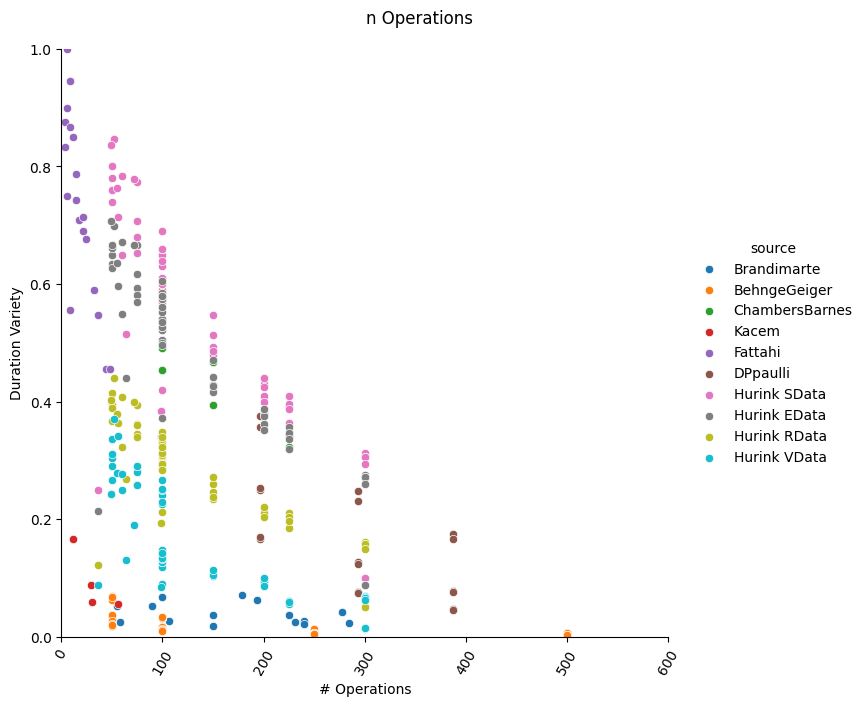

In [29]:
fg = sns.FacetGrid(data=df_diff, hue='source', aspect=1)
fg.fig.suptitle("n Operations")
fg.set(ylim=(0, 1.0))
fg.set(xlim=(0, 600))
fg.fig.set_size_inches(7,7)
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

for t in fg._legend.texts:
    t.set_text(clean_labels[t.get_text()])

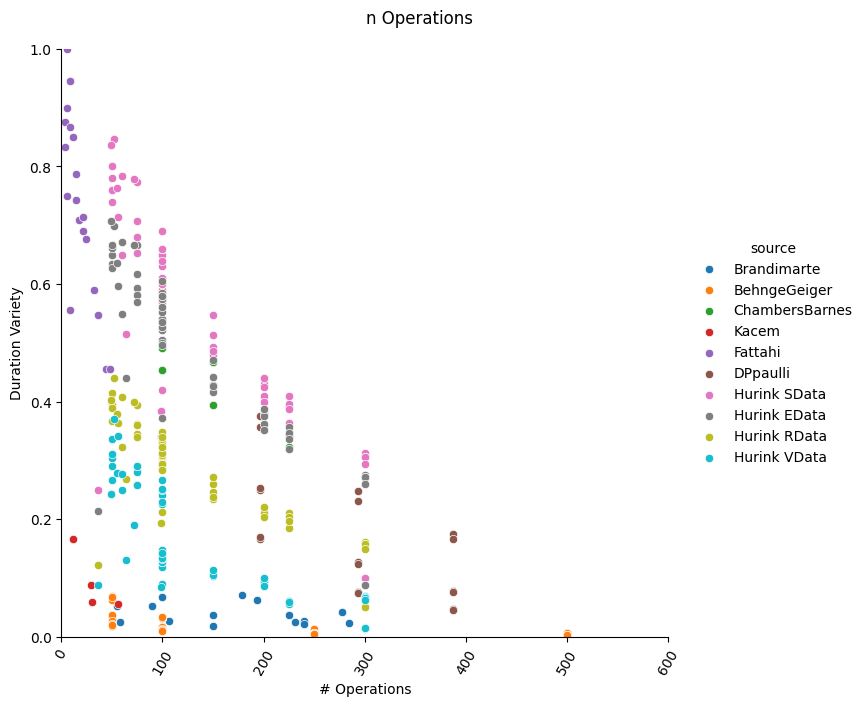

In [30]:
fg = sns.FacetGrid(data=df_diff, hue='source', aspect=1)
fg.fig.suptitle("n Operations")
fg.set(ylim=(0, 1.0))
fg.set(xlim=(0, 600))
fg.fig.set_size_inches(7,7)
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

for t in fg._legend.texts:
    t.set_text(clean_labels[t.get_text()])

In [31]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=1)
fg.fig.set_size_inches(7,7)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='average_machines_per_operation', y='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('# Operations')
fg.set_xlabels('Avg. Machines per Operation')

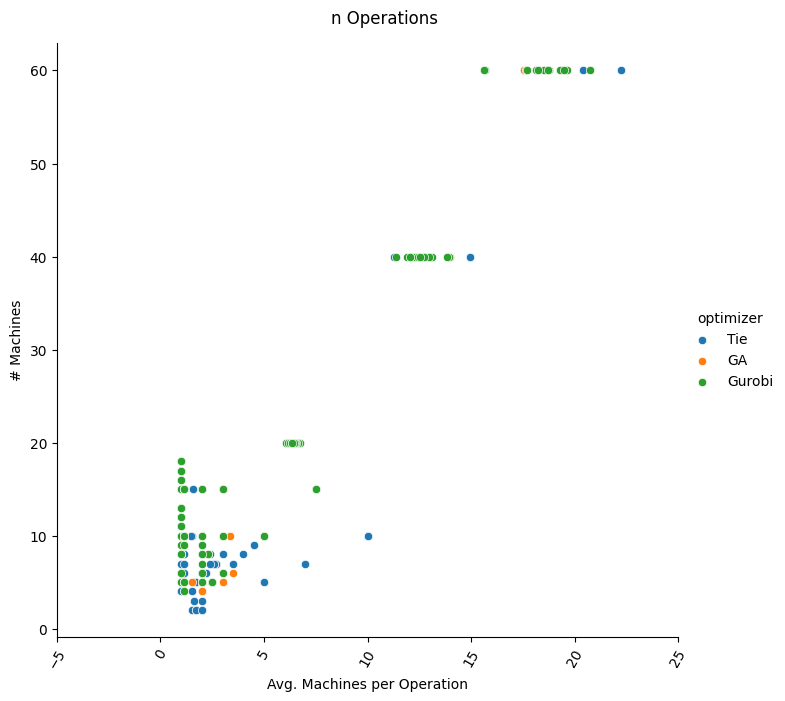

In [32]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=1)
fg.fig.set_size_inches(7,7)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='average_machines_per_operation', y='n_machines').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('# Machines')
fg.set_xlabels('Avg. Machines per Operation')

In [33]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=1)
fg.fig.set_size_inches(7,7)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='average_machines_per_operation', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('Avg. Machines per Operation')

In [34]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] != 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

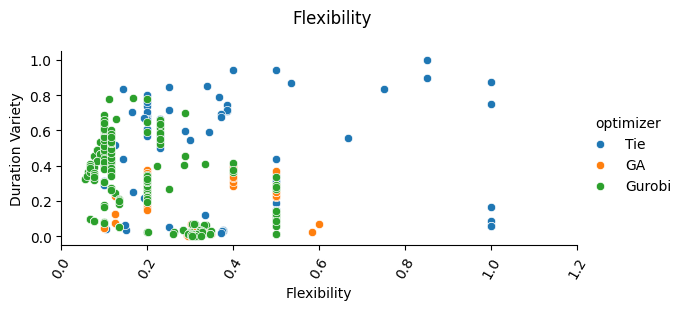

In [35]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('Flexibility')

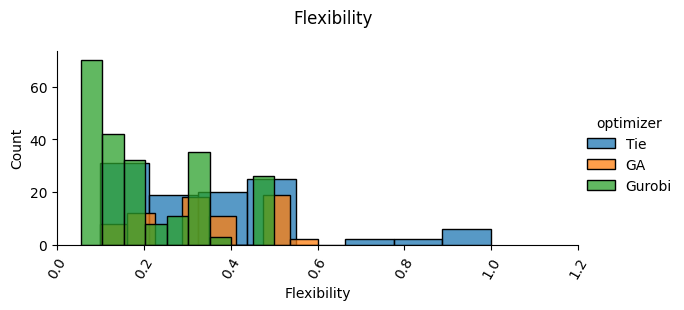

In [36]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.histplot, x='beta_flexibility').add_legend().set_xticklabels(rotation=60)

fg.set_xlabels('Flexibility')

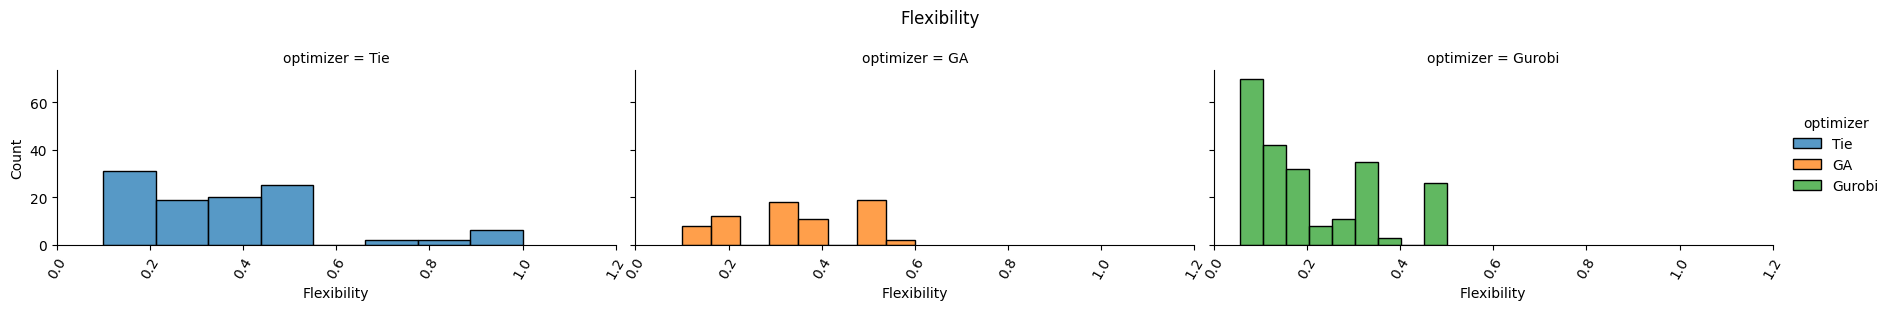

In [37]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='optimizer')
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.histplot, x='beta_flexibility').add_legend().set_xticklabels(rotation=60)

fg.set_xlabels('Flexibility')

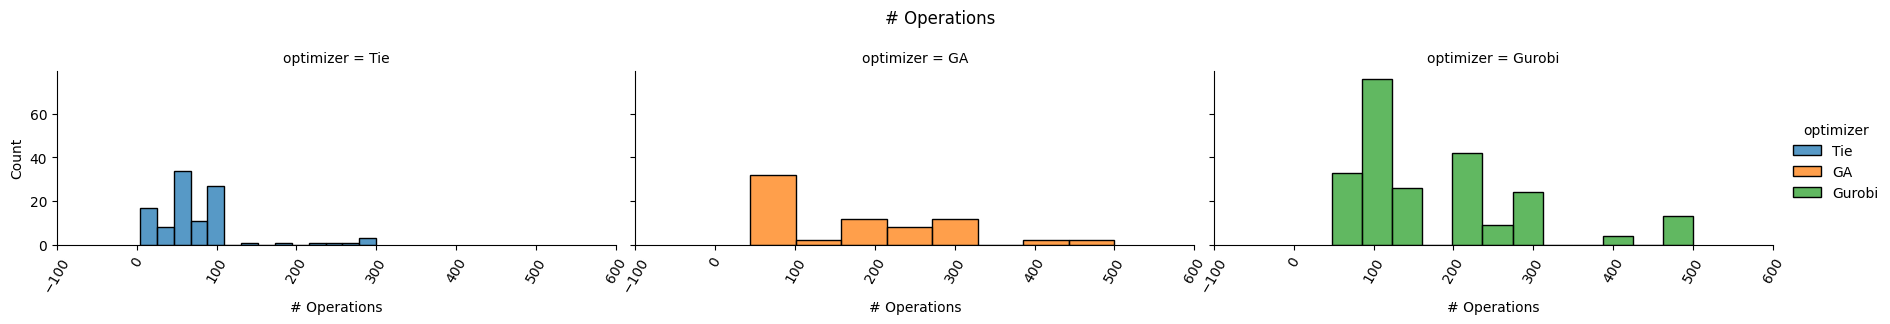

In [38]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='optimizer')
fg.fig.suptitle("# Operations")
fg.map_dataframe(sns.histplot, x='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('# Operations')

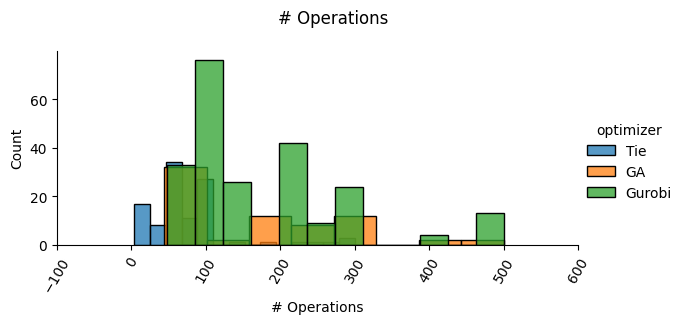

In [39]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("# Operations")
fg.map_dataframe(sns.histplot, x='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('# Operations')

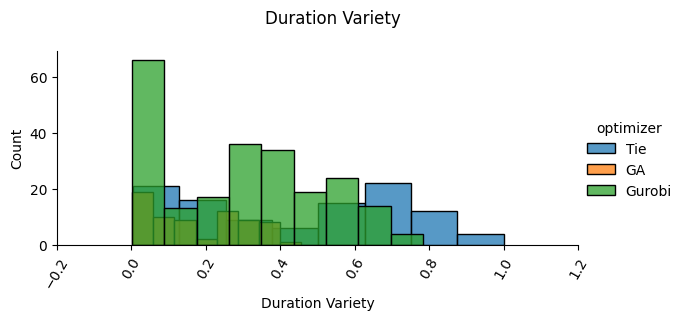

In [40]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

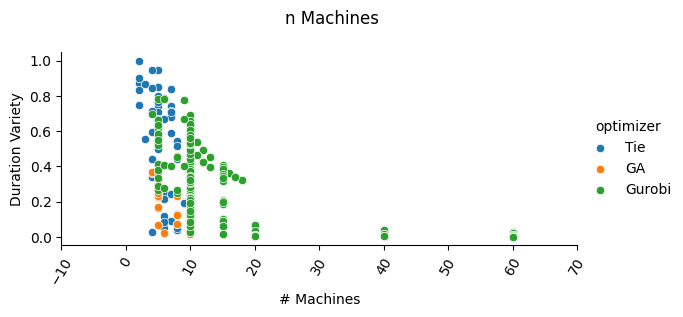

In [41]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("n Machines")
fg.map_dataframe(sns.scatterplot, x='n_machines', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Machines')

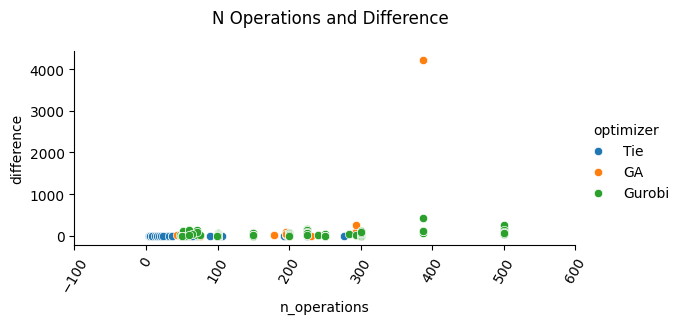

In [42]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("N Operations and Difference")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='difference').add_legend().set_xticklabels(rotation=60)

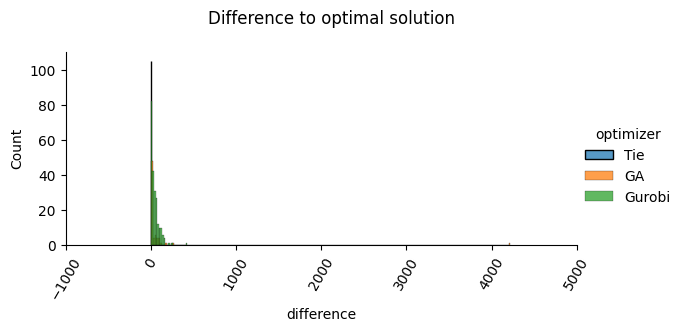

In [43]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference to optimal solution")
fg.map_dataframe(sns.histplot, x='difference').add_legend().set_xticklabels(rotation=60)

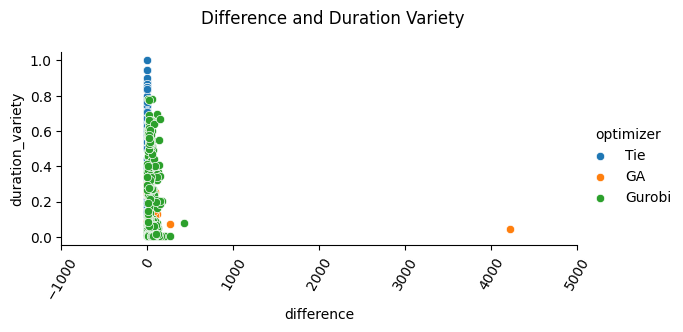

In [44]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Duration Variety")
fg.map_dataframe(sns.scatterplot, x='difference', y='duration_variety').add_legend().set_xticklabels(rotation=60)

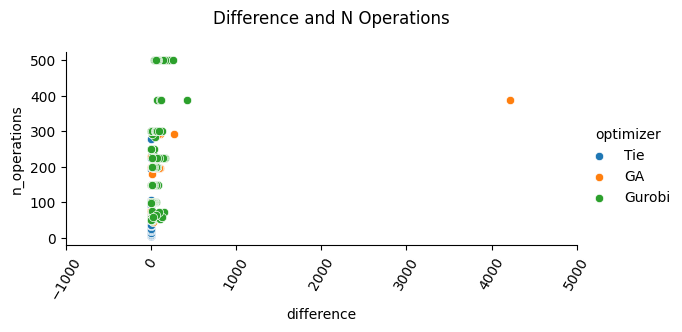

In [45]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Operations")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_operations').add_legend().set_xticklabels(rotation=60)

In [46]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Operations")
fg.map_dataframe(sns.scatterplot, x='difference', y='approximate_max_dissimilarity').add_legend().set_xticklabels(rotation=60)

In [47]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Jobs")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_job').add_legend().set_xticklabels(rotation=60)

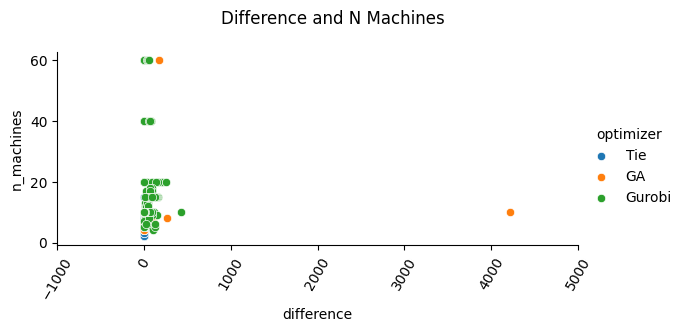

In [48]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Machines")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_machines').add_legend().set_xticklabels(rotation=60)

In [49]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='difference', y='average_machines_per_operation').add_legend().set_xticklabels(rotation=60)

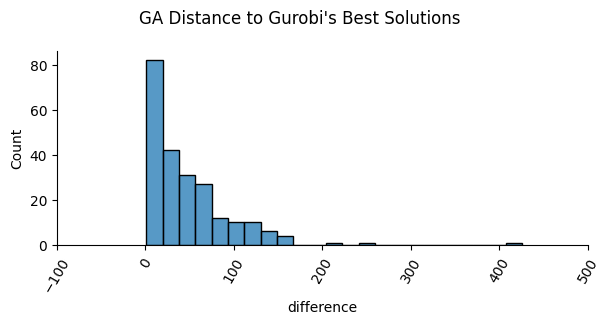

In [50]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Gurobi'], aspect=2)
fg.fig.suptitle("GA Distance to Gurobi's Best Solutions")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

In [51]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'GA'], aspect=2)
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

In [52]:
df_diff.loc[df_diff['difference'] > 2000]

source  instance           uid  best_objective  n_machines  n_job  \
137  3_DPpaulli        18  3_DPpaulli18          2744.0          10     20   

     average_machines_per_operation  n_operations  average_operations_per_job  \
137                             1.0           387                       19.35   

     beta_flexibility  approximate_max_dissimilarity  duration_variety  \
137               0.1                         406.35          0.045853   

     fevals_GA  fevals_Gurobi  fevals_difference  abs_fevals_difference  \
137     275325            630            -274695                 274695   

     log_fevals_difference optimizer  difference source_abbreviation  
137              -5.438851        GA      4221.0                   3

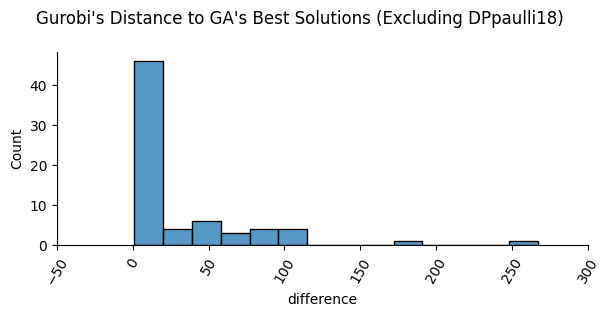

In [53]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') & (df_diff['difference'] < 4000)], aspect=2)
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

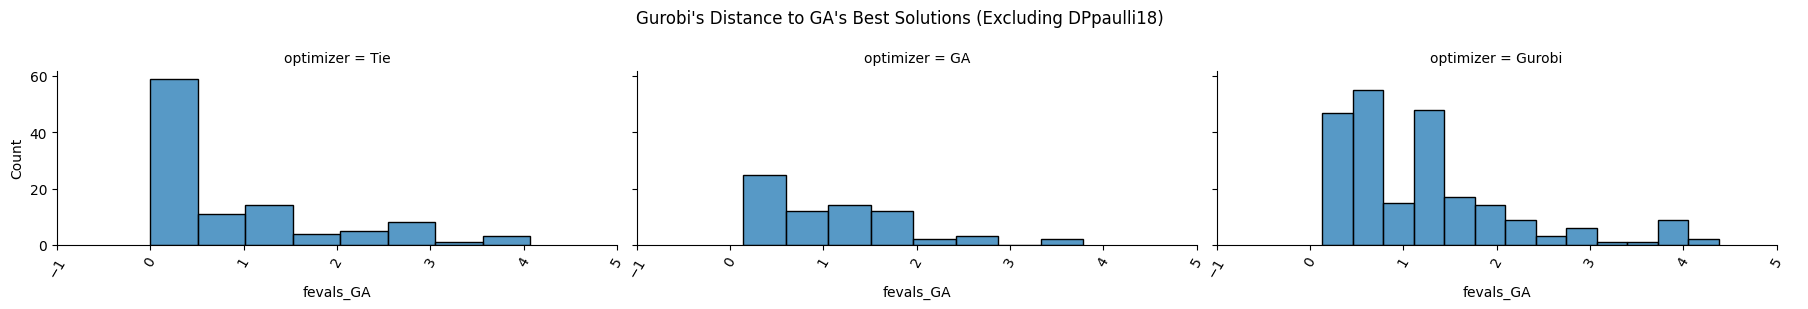

In [54]:
fg = sns.FacetGrid(data=df_diff, aspect=2, col='optimizer')
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='fevals_GA',).add_legend().set_xticklabels(rotation=60)

In [55]:
fg = sns.FacetGrid(data=df_diff, aspect=2, col='optimizer')
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='fevals_Gurobi',).add_legend().set_xticklabels(rotation=60)

In [56]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='difference').add_legend().set_xticklabels(rotation=60)

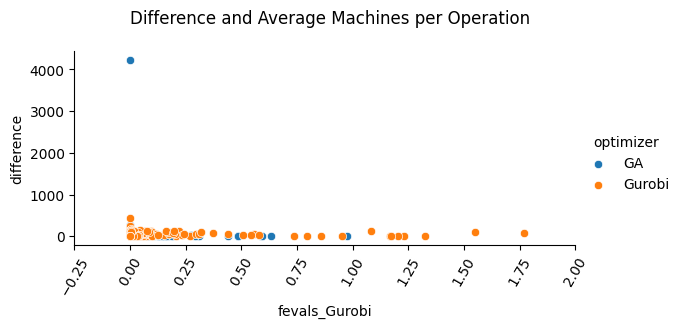

In [57]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') | (df_diff['optimizer'] == 'Gurobi')], hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_Gurobi', y='difference').add_legend().set_xticklabels(rotation=60)

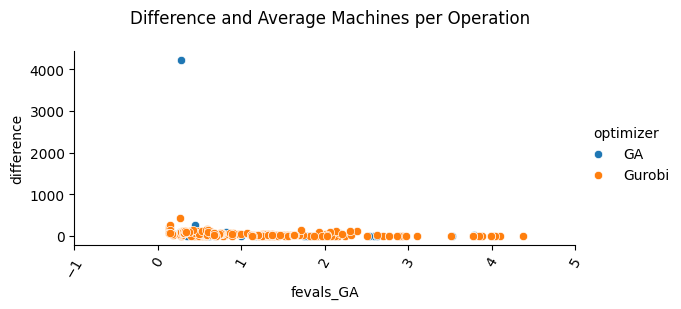

In [58]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') | (df_diff['optimizer'] == 'Gurobi')], hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='difference').add_legend().set_xticklabels(rotation=60)

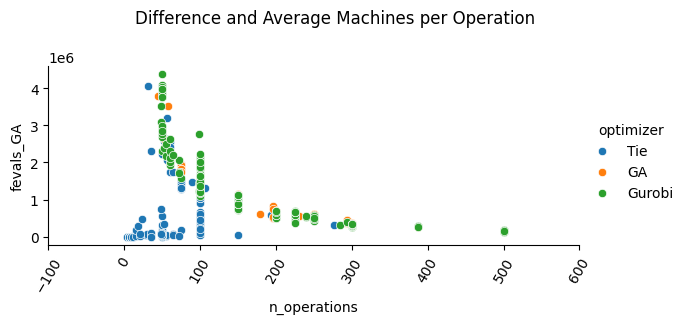

In [59]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA').add_legend().set_xticklabels(rotation=60)

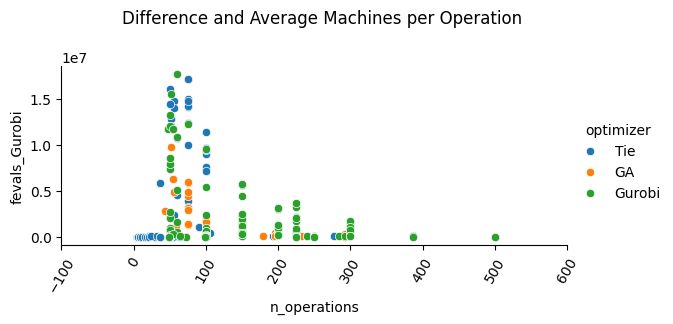

In [60]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi').add_legend().set_xticklabels(rotation=60)

In [61]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], aspect=2)
fg.fig.suptitle("Feval Difference (N Operations)")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('# Operations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

In [62]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Best Objective)")
fg.map_dataframe(sns.scatterplot, x='best_objective', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='best_objective', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

In [63]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Duration Variety)")
fg.map_dataframe(sns.scatterplot, x='duration_variety', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='duration_variety', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

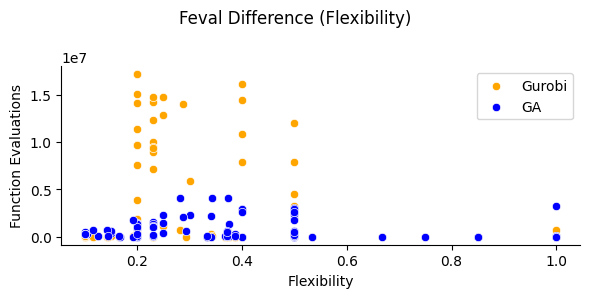

In [64]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Flexibility)")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

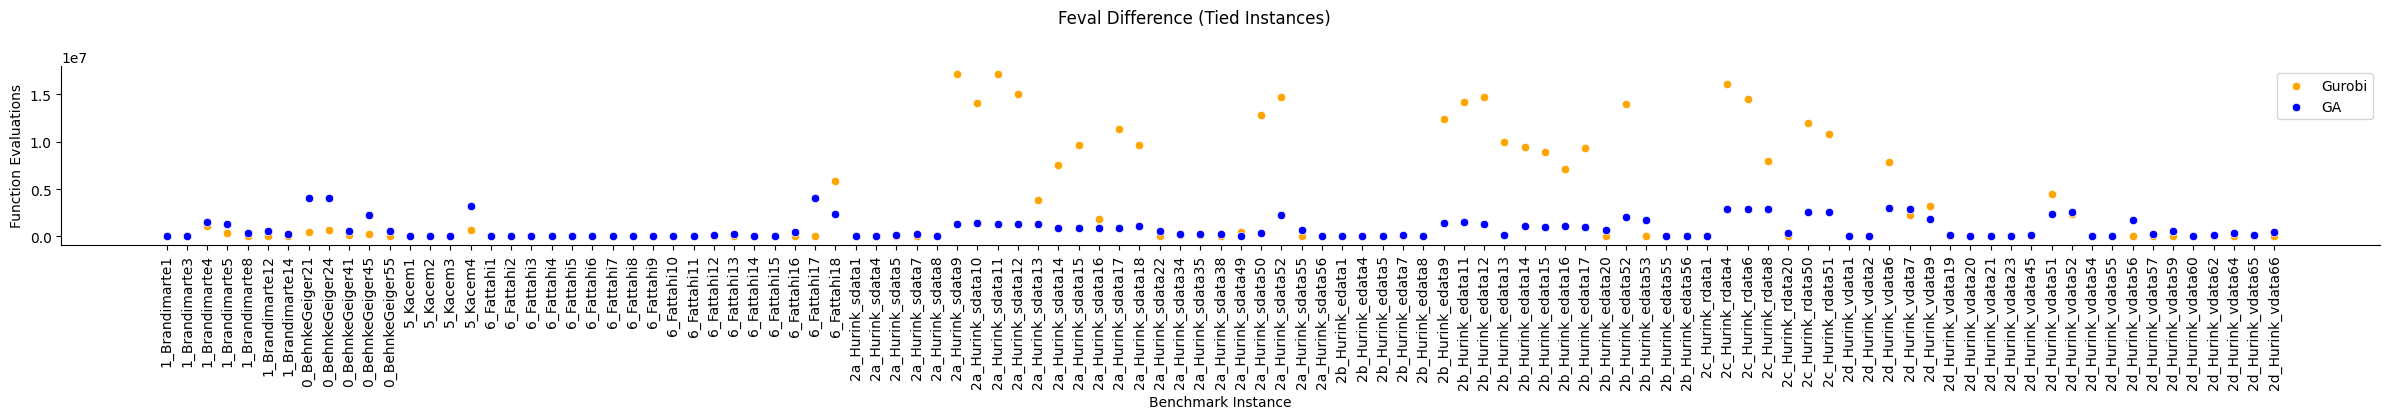

In [65]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=8)
fg.fig.suptitle("Feval Difference (Tied Instances)")
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Benchmark Instance')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

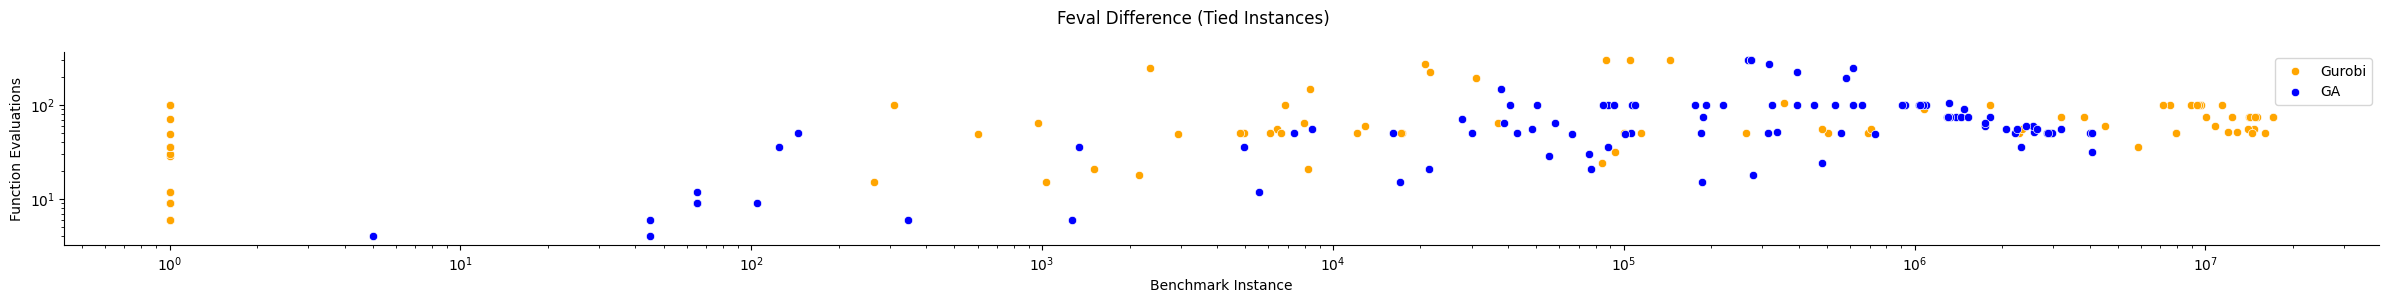

In [66]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=8)
fg.fig.suptitle("Feval Difference (Tied Instances)")
fg.map_dataframe(sns.scatterplot, x='fevals_Gurobi', y='n_operations', color='orange')
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='n_operations', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Benchmark Instance')
#fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

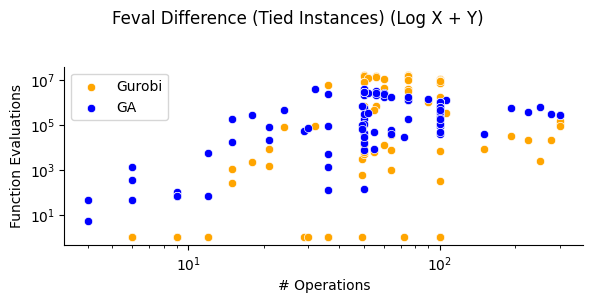

In [67]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Tied Instances) (Log X + Y)")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('# Operations')
#fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

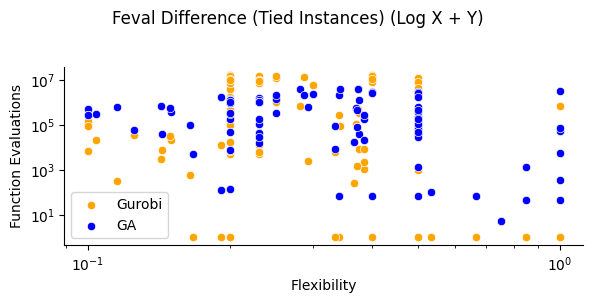

In [68]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Tied Instances) (Log X + Y)")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
#fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

In [69]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] != 'Tie'], hue='optimizer', aspect=8)
fg.fig.suptitle("Feval Difference (Instances)")
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

In [70]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['uid'] != '3_DPpaulli18')], hue='optimizer', aspect=8)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

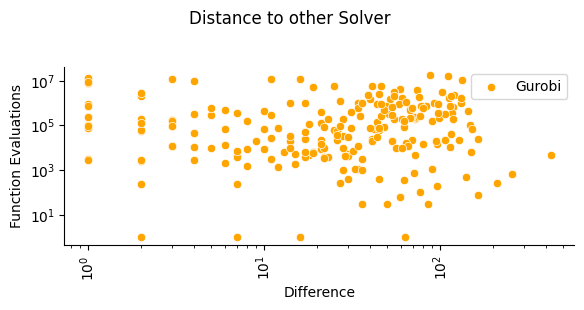

In [71]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Gurobi') & (df_diff['uid'] != '3_DPpaulli18')], hue='optimizer', aspect=2)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_Gurobi', color='orange')
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

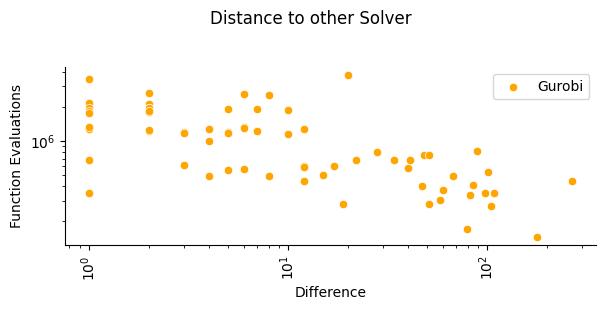

In [72]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') & (df_diff['uid'] != '3_DPpaulli18')], hue='optimizer', aspect=2)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='orange')
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

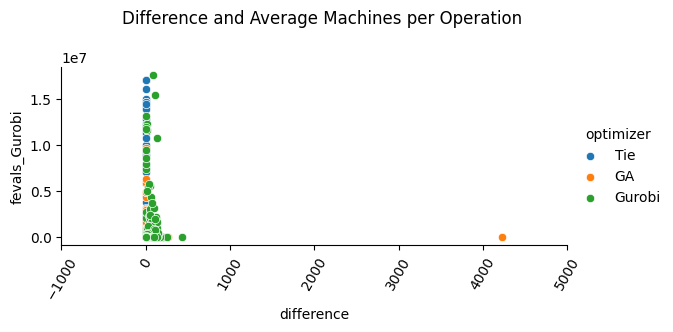

In [73]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_Gurobi').add_legend().set_xticklabels(rotation=60)

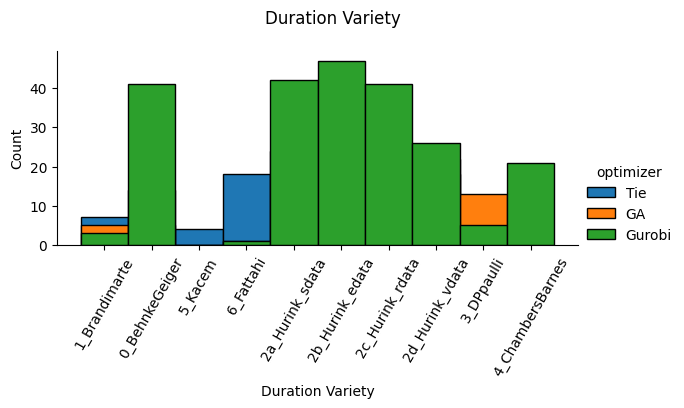

In [74]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='source', alpha=1, ).add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

[Text(0, 0, '1_Brandimarte'), Text(1, 0, '0_BehnkeGeiger'), Text(2, 0, '5_Kacem'), Text(3, 0, '6_Fattahi'), Text(4, 0, '2a_Hurink_sdata'), Text(5, 0, '2b_Hurink_edata'), Text(6, 0, '2c_Hurink_rdata'), Text(7, 0, '2d_Hurink_vdata'), Text(8, 0, '3_DPpaulli'), Text(9, 0, '4_ChambersBarnes')]


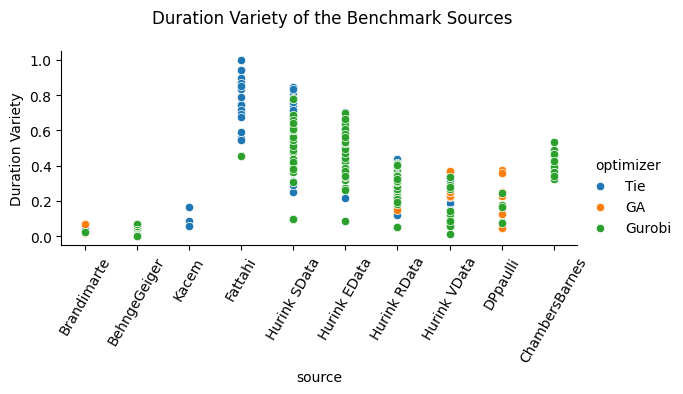

In [75]:
import matplotlib
#plt.xlabel('', fontsize=16)
matplotlib.rcParams.update({'font.size': 10})


fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
#sns.set() # small font size? 
fg.fig.suptitle("Duration Variety of the Benchmark Sources")
fg.map_dataframe(sns.scatterplot, x='source', y='duration_variety').add_legend().set_xticklabels(rotation=60)
labels = fg.axes.flat[0].get_xticklabels()
for ax in fg.axes.flat:
    labels = ax.get_xticklabels()
    print(labels)
use_labels = [clean_labels[x.get_text()] for x in labels]
fg.set_xticklabels(use_labels, rotation=60)
#fg.set_xlabels('Duration Variety')
fg.set_ylabels('Duration Variety')

[Text(0, 0, '1_Brandimarte'), Text(1, 0, '0_BehnkeGeiger'), Text(2, 0, '4_ChambersBarnes'), Text(3, 0, '5_Kacem'), Text(4, 0, '6_Fattahi'), Text(5, 0, '3_DPpaulli'), Text(6, 0, '2a_Hurink_sdata'), Text(7, 0, '2b_Hurink_edata'), Text(8, 0, '2c_Hurink_rdata'), Text(9, 0, '2d_Hurink_vdata')]


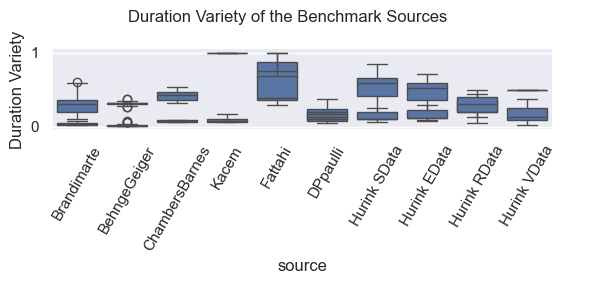

In [113]:
import matplotlib
#plt.xlabel('', fontsize=16)
matplotlib.rcParams.update({'font.size': 10})


fg = sns.FacetGrid(data=df_diff, aspect=2)

fg.fig.suptitle("Duration Variety of the Benchmark Sources")
fg.map_dataframe(sns.boxplot, x='source', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.map_dataframe(sns.boxplot, x='source', y='beta_flexibility')
labels = fg.axes.flat[0].get_xticklabels()
for ax in fg.axes.flat:
    labels = ax.get_xticklabels()
    print(labels)
use_labels = [clean_labels[x.get_text()] for x in labels]
fg.set_xticklabels(use_labels, rotation=60)
#fg.set_xlabels('Duration Variety')
fg.set_ylabels('Duration Variety')


In [116]:
sns.boxplot(data=df_diff, x='source', y='beta_flexibility')

<AxesSubplot: xlabel='source', ylabel='beta_flexibility'>

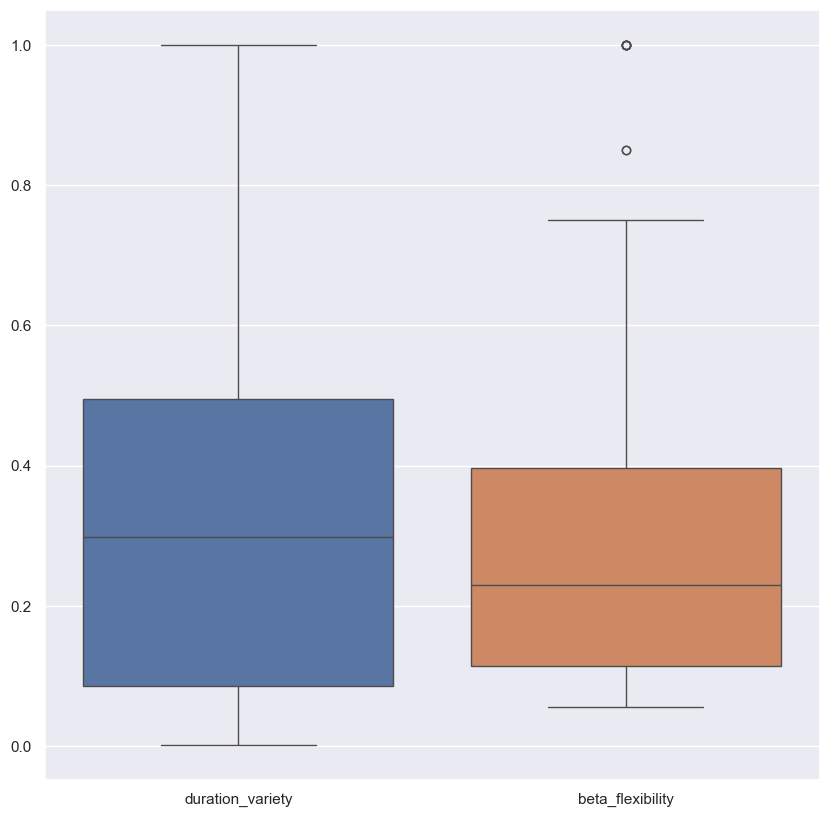

In [118]:
ax = sns.boxplot(data=df_diff[['duration_variety', 'beta_flexibility']])

In [128]:
df_diff.head()

source  instance             uid  best_objective  n_machines  n_job  \
0  1_Brandimarte         1  1_Brandimarte1            40.0           6     10   
1  1_Brandimarte         2  1_Brandimarte2            26.0           6     10   
2  1_Brandimarte         3  1_Brandimarte3           204.0           8     15   
3  1_Brandimarte         4  1_Brandimarte4            60.0           8     15   
4  1_Brandimarte         5  1_Brandimarte5           173.0           4     15   

   average_machines_per_operation  n_operations  average_operations_per_job  \
0                             2.0            55                    5.500000   
1                             3.5            58                    5.800000   
2                             3.0           150                   10.000000   
3                             2.0            90                    6.000000   
4                             1.5           106                    7.066667   

   beta_flexibility  approximate_max_dissimilarity  duration_variety  \
0          0.333333                           66.0          0.052174   
1          0.583333                           78.3          0.025210   
2          0.375000                          180.0          0.037694   
3          0.250000                          102.0          0.052326   
4          0.375000                          116.6          0.027624   

   fevals_GA  fevals_Gurobi  fevals_difference  abs_fevals_difference  \
0       8470           6401              -2069                   2069   
1    3518230        1025776           -2492454                2492454   
2      37880           8325             -29555                  29555   
3    1480295        1074732            -405563                 405563   
4    1314545         354312            -960233                 960233   

   log_fevals_difference optimizer  difference source_abbreviation  
0              -3.315760       Tie         0.0                   1  
1              -6.396627        GA         1.0                   1  
2              -4.470631       Tie         0.0                   1  
3              -5.608058       Tie         0.0                   1  
4              -5.982377       Tie         0.0                   1

<AxesSubplot: xlabel='source', ylabel='duration_variety'>

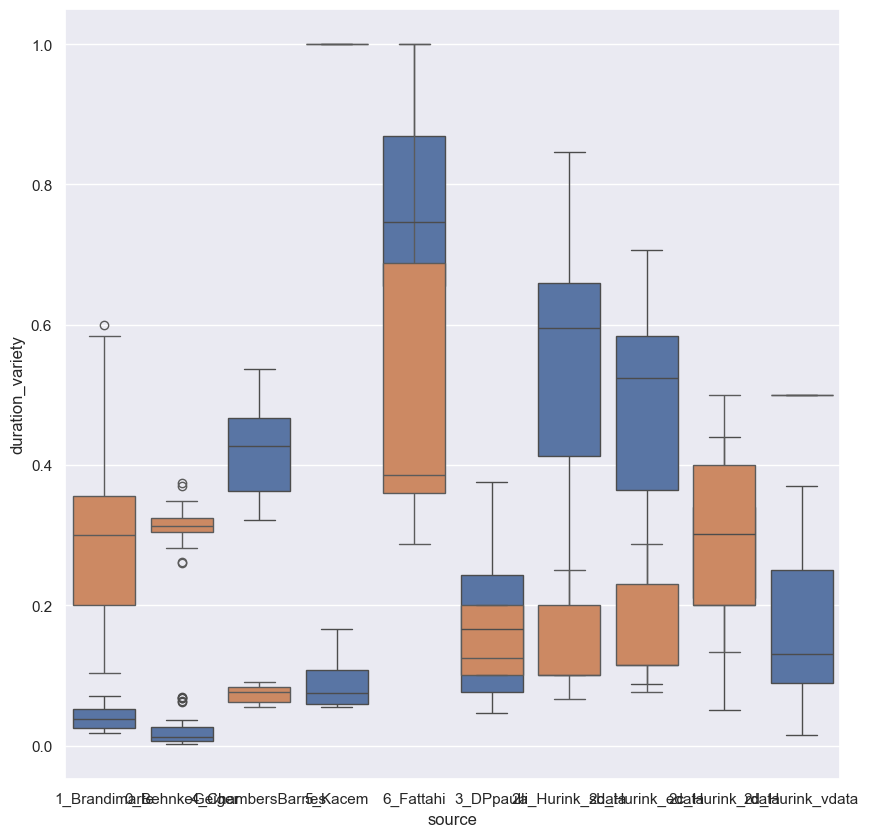

In [138]:

sns.boxplot(data=df_diff, x='source', y='duration_variety')

sns.boxplot(data=df_diff, x='source', y='beta_flexibility')

In [145]:
test_df = df_diff[['source', 'duration_variety', 'beta_flexibility']]

In [149]:
data = test_df.melt(id_vars=['source'], var_name='dataset', value_name='values')

In [147]:
data

source           dataset    values
0      1_Brandimarte  duration_variety  0.052174
1      1_Brandimarte  duration_variety  0.025210
2      1_Brandimarte  duration_variety  0.037694
3      1_Brandimarte  duration_variety  0.052326
4      1_Brandimarte  duration_variety  0.027624
..               ...               ...       ...
799  2d_Hurink_vdata  beta_flexibility  0.500000
800  2d_Hurink_vdata  beta_flexibility  0.500000
801  2d_Hurink_vdata  beta_flexibility  0.500000
802  2d_Hurink_vdata  beta_flexibility  0.500000
803  2d_Hurink_vdata  beta_flexibility  0.500000

[804 rows x 3 columns]

In [162]:
custom_labels = {
    '0_BehnkeGeiger': 'BehnkeGeiger(n=60)',
    '1_Brandimarte': 'Brandimarte(n=15)',
    '2a_Hurink_sdata': 'Hurink SData(n=66)',
    '2b_Hurink_edata': 'Hurink EData(n=66)',
    '2c_Hurink_rdata': 'Hurink RData(n=66)',
    '2d_Hurink_vdata': 'Hurink VData(n=66)',
    '3_DPpaulli' : 'DPpaulli(n=18)',
    '4_ChambersBarnes': 'ChambersBarnes(n=21)',
    '5_Kacem': 'Kacem(n=4)',
    '6_Fattahi': 'Fattahi(n=20)'
}
#data = df_diff.melt(id_vars=['source'], var_name='dataset', value_name='values')
p =sns.boxplot(data=data, x='source', y='values', hue='dataset')
plt.ylabel('Value')
plt.xlabel('')
plt.legend(title='Value', loc='upper left', bbox_to_anchor=(1, 1))
labels = p.axes.get_xticklabels()

labels = ax.get_xticklabels()
print(labels)
use_labels = [custom_labels[x.get_text()] for x in labels]
#plt.xticks(use_labels, rotation=60)
p.set(xticklabels=use_labels)
plt.xticks(rotation=60)

[Text(0, 0, '1_Brandimarte'), Text(1, 0, '0_BehnkeGeiger'), Text(2, 0, '4_ChambersBarnes'), Text(3, 0, '5_Kacem'), Text(4, 0, '6_Fattahi'), Text(5, 0, '3_DPpaulli'), Text(6, 0, '2a_Hurink_sdata'), Text(7, 0, '2b_Hurink_edata'), Text(8, 0, '2c_Hurink_rdata'), Text(9, 0, '2d_Hurink_vdata')]


C:\Users\huda\AppData\Local\Temp\ipykernel_8548\3665346265.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set(xticklabels=use_labels)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Brandimarte(n=15)'),
  Text(1, 0, 'BehnkeGeiger(n=60)'),
  Text(2, 0, 'ChambersBarnes(n=21)'),
  Text(3, 0, 'Kacem(n=4)'),
  Text(4, 0, 'Fattahi(n=20)'),
  Text(5, 0, 'DPpaulli(n=18)'),
  Text(6, 0, 'Hurink SData(n=66)'),
  Text(7, 0, 'Hurink EData(n=66)'),
  Text(8, 0, 'Hurink RData(n=66)'),
  Text(9, 0, 'Hurink VData(n=66)')])

In [131]:
import matplotlib
#plt.xlabel('', fontsize=16)
matplotlib.rcParams.update({'font.size': 10})


fg = sns.FacetGrid(data=df_diff, aspect=2)

fg.fig.suptitle("Duration Variety of the Benchmark Sources")
fg.boxplot(data=df_diff, x='source', y='duration_variety', dodge='auto').add_legend().set_xticklabels(rotation=60)
fg.boxplot(data=df_diff, x='source', y='beta_flexibility', dodge='auto')
labels = fg.axes.flat[0].get_xticklabels()
for ax in fg.axes.flat:
    labels = ax.get_xticklabels()
    print(labels)
use_labels = [clean_labels[x.get_text()] for x in labels]
fg.set_xticklabels(use_labels, rotation=60)
#fg.set_xlabels('Duration Variety')
fg.set_ylabels('Duration Variety')


TypeError: Axes.bxp() got an unexpected keyword argument 'aspect'

In [76]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=1, height=4, hue_kws=dict(marker=["X", "D", 'o']), hue_order=['Tie', 'Gurobi', 'GA'], palette=['C1', 'C2', 'C0'])

fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='duration_variety', s=20).set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('Flexibility')
fg.set(ylim=(0, 1.0))
fg.set(xlim=(0, 1.0))
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[::-1], labels=labels[::-1], title='Best Result', loc='center right')
plt.show()

In [77]:
sns.set(rc={"figure.figsize":(10, 10)})
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=1, height=4, hue_kws=dict(marker=["X", "D", 'o']), hue_order=['Tie', 'Gurobi', 'GA'], palette=['C1', 'C2', 'C0'])

fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety', s=20).set_xticklabels(rotation=60)
handles, labels = plt.gca().get_legend_handles_labels()
fg.set_ylabels('Duration Variety')
fg.set_xlabels('n-Operations')
fg.set(ylim=(0, 1.0))
fg.set(xlim=(0, 500))
plt.legend(handles=handles[::-1], labels=labels[::-1], title='Best Result')
plt.show()

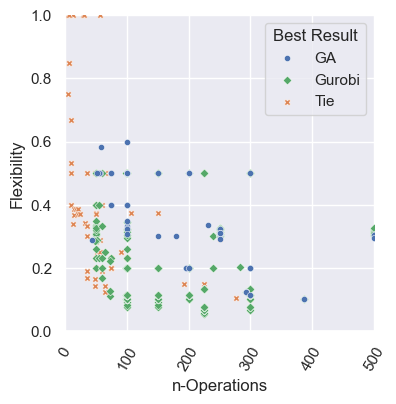

In [78]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=1, height=4, hue_kws=dict(marker=["X", "D", 'o']), hue_order=['Tie', 'Gurobi', 'GA'], palette=['C1', 'C2', 'C0'])

fg.map_dataframe(sns.scatterplot, x='n_operations', y='beta_flexibility', s=20).set_xticklabels(rotation=60)
handles, labels = plt.gca().get_legend_handles_labels()
fg.set_ylabels('Flexibility')
fg.set_xlabels('n-Operations')
fg.set(ylim=(0, 1.0))
fg.set(xlim=(0, 500))
plt.legend(handles=handles[::-1], labels=labels[::-1], title='Best Result')
plt.show()

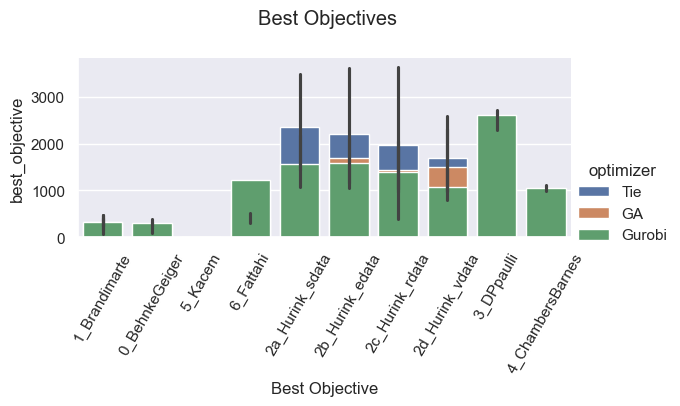

In [79]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Best Objectives")
fg.map_dataframe(sns.barplot, x='source', y='best_objective', dodge=True).add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Best Objective')

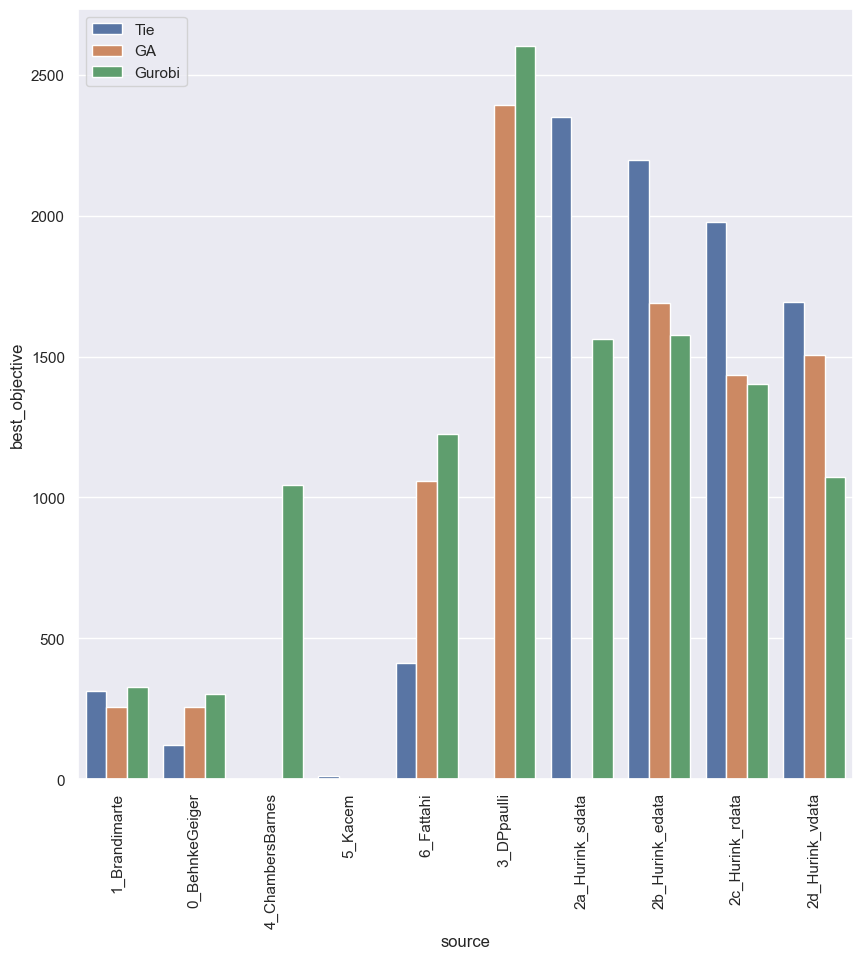

In [80]:
g = sns.barplot(data=df_diff, x='source', y='best_objective', hue='optimizer', errorbar=None)
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()


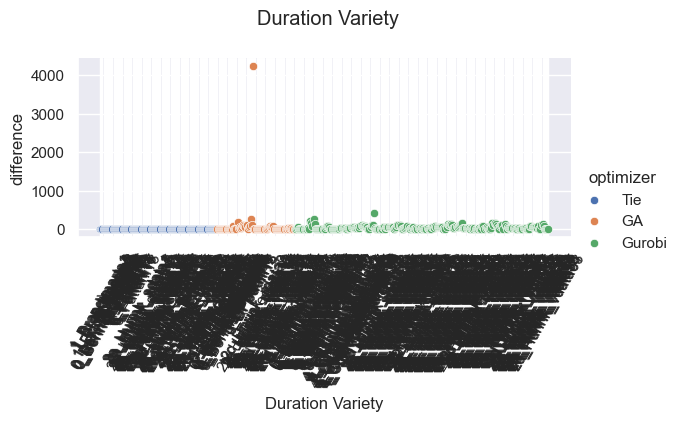

In [81]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.scatterplot, x='uid', y='difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

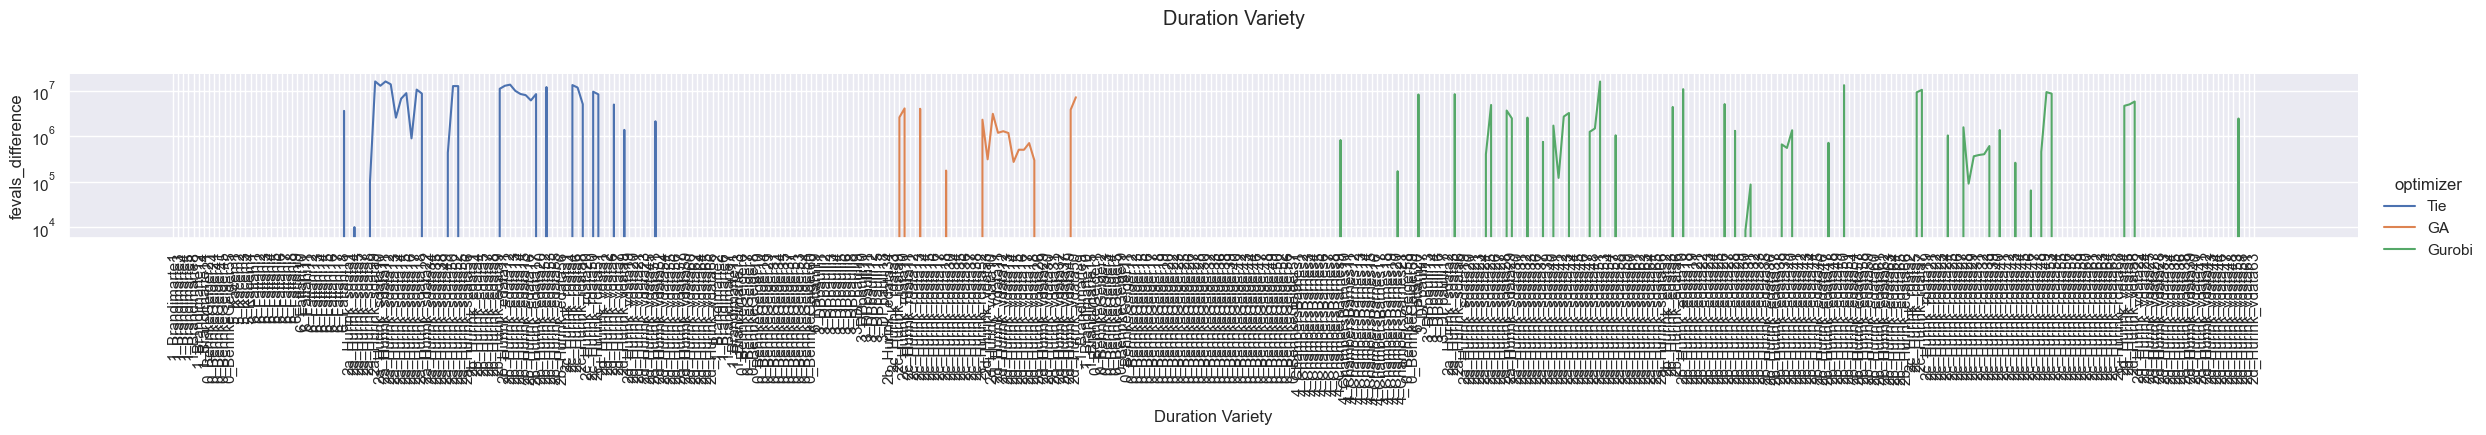

In [82]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=90)
fg.set_xlabels('Duration Variety')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
#plt.tight_layout()
plt.yscale('log')
plt.show(fg)

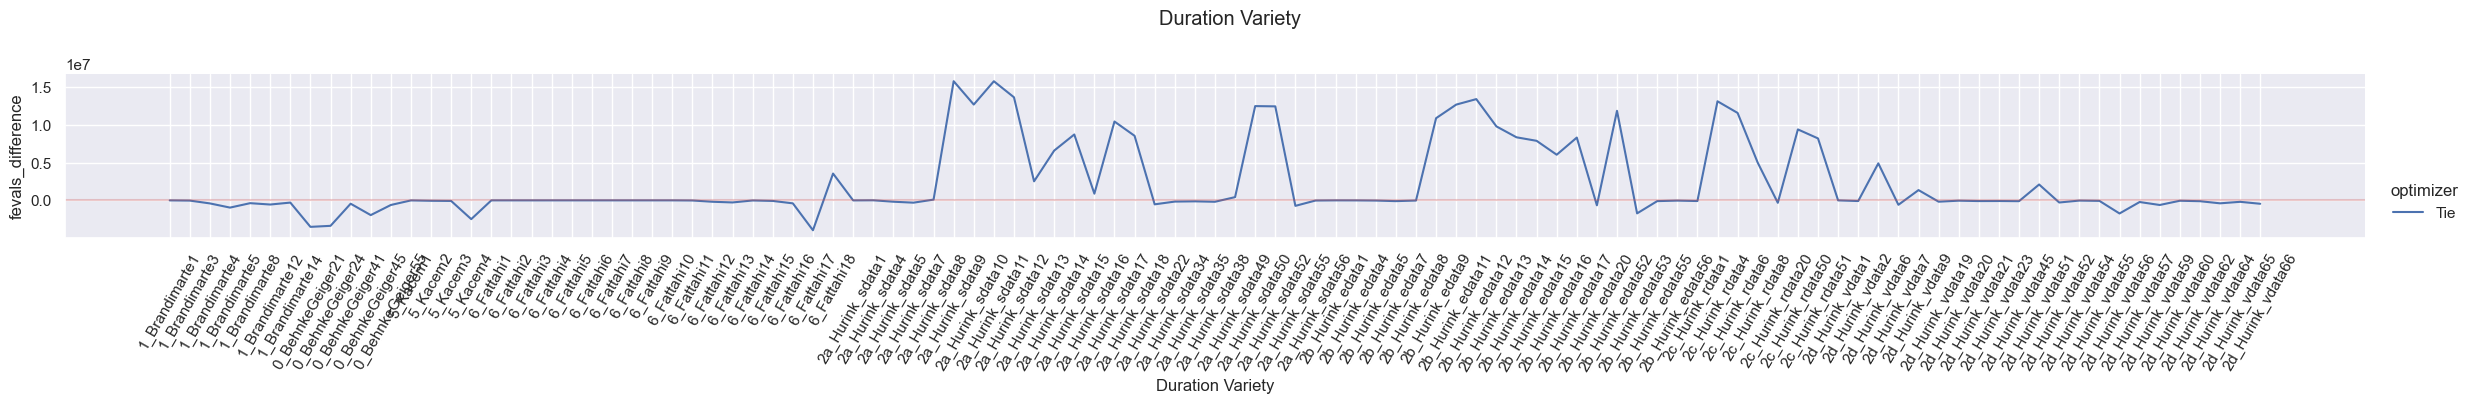

In [83]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
#plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

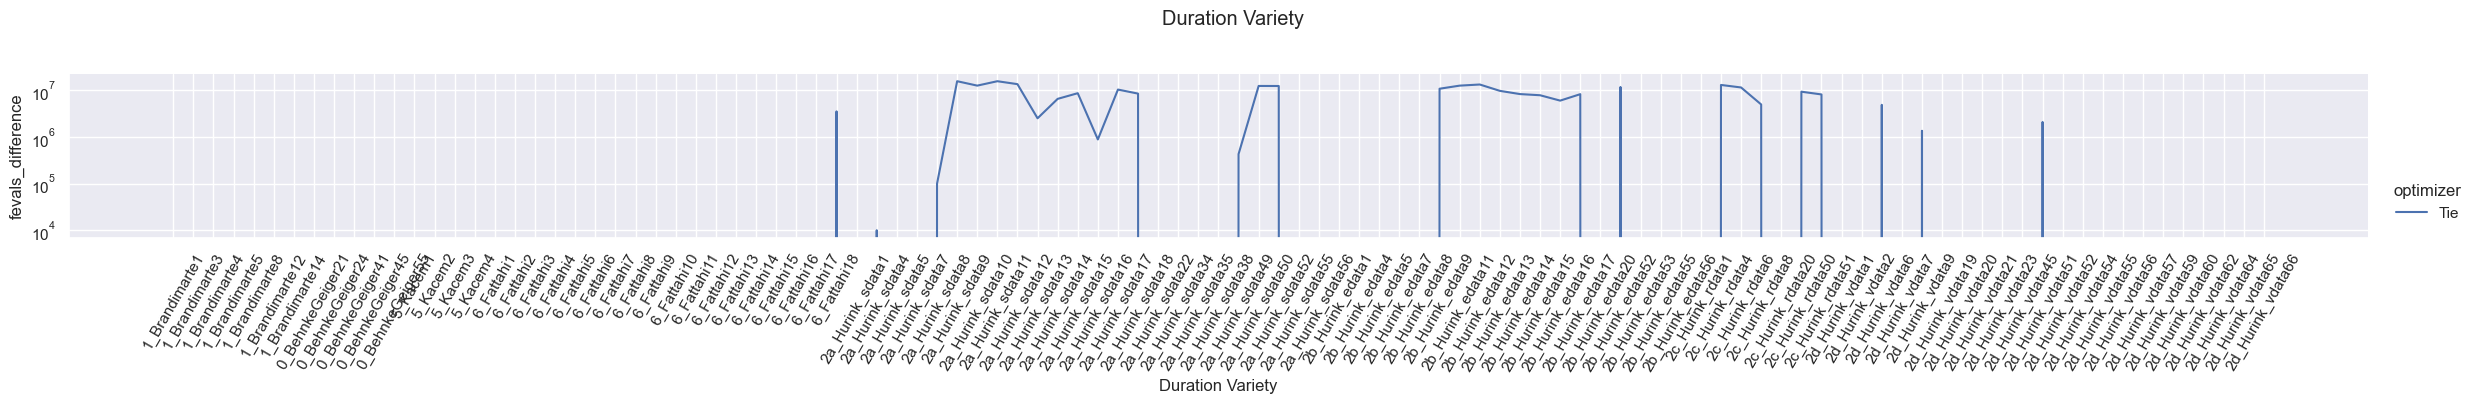

In [84]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

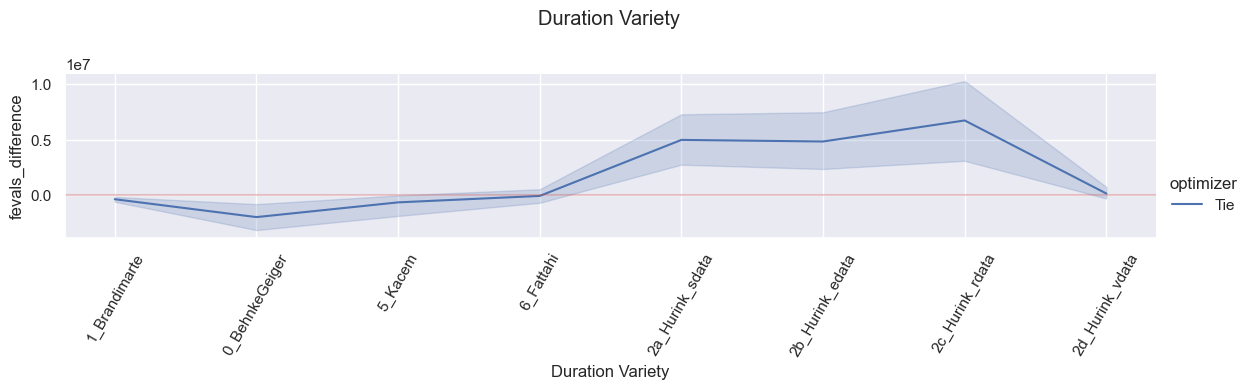

In [85]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=4)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='source', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
#plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

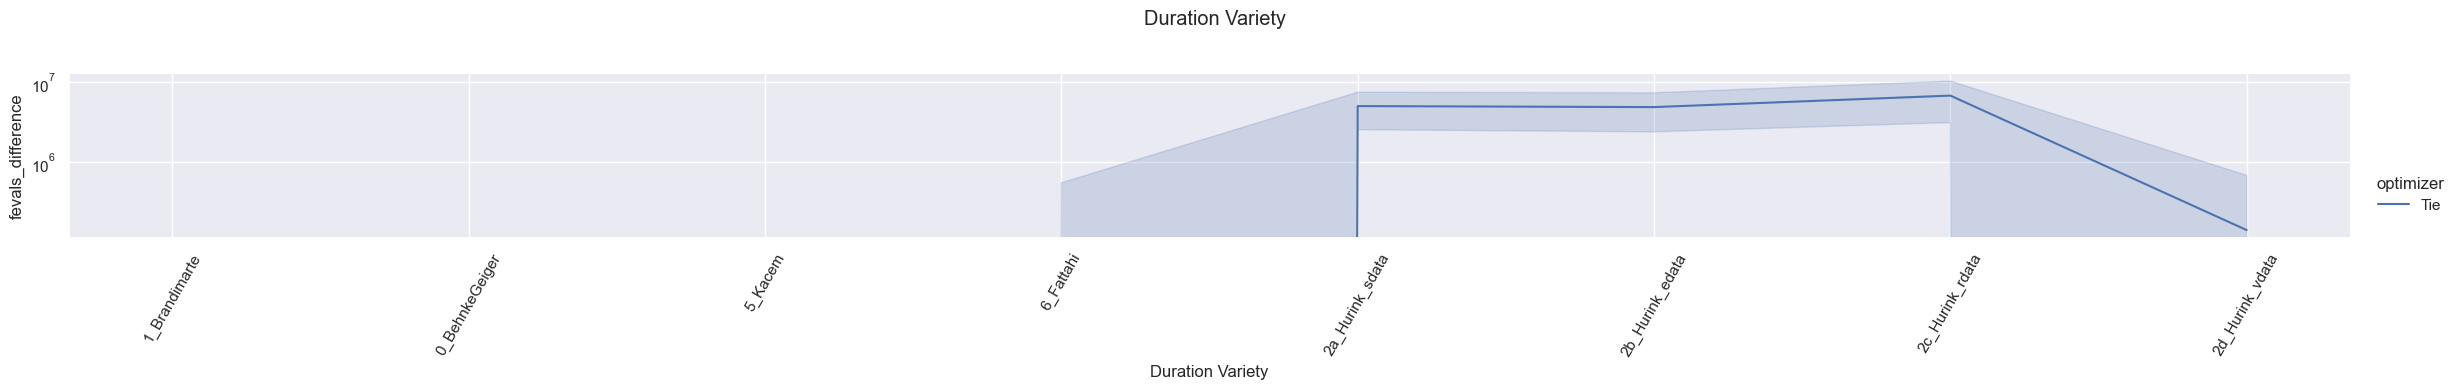

In [86]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='source', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

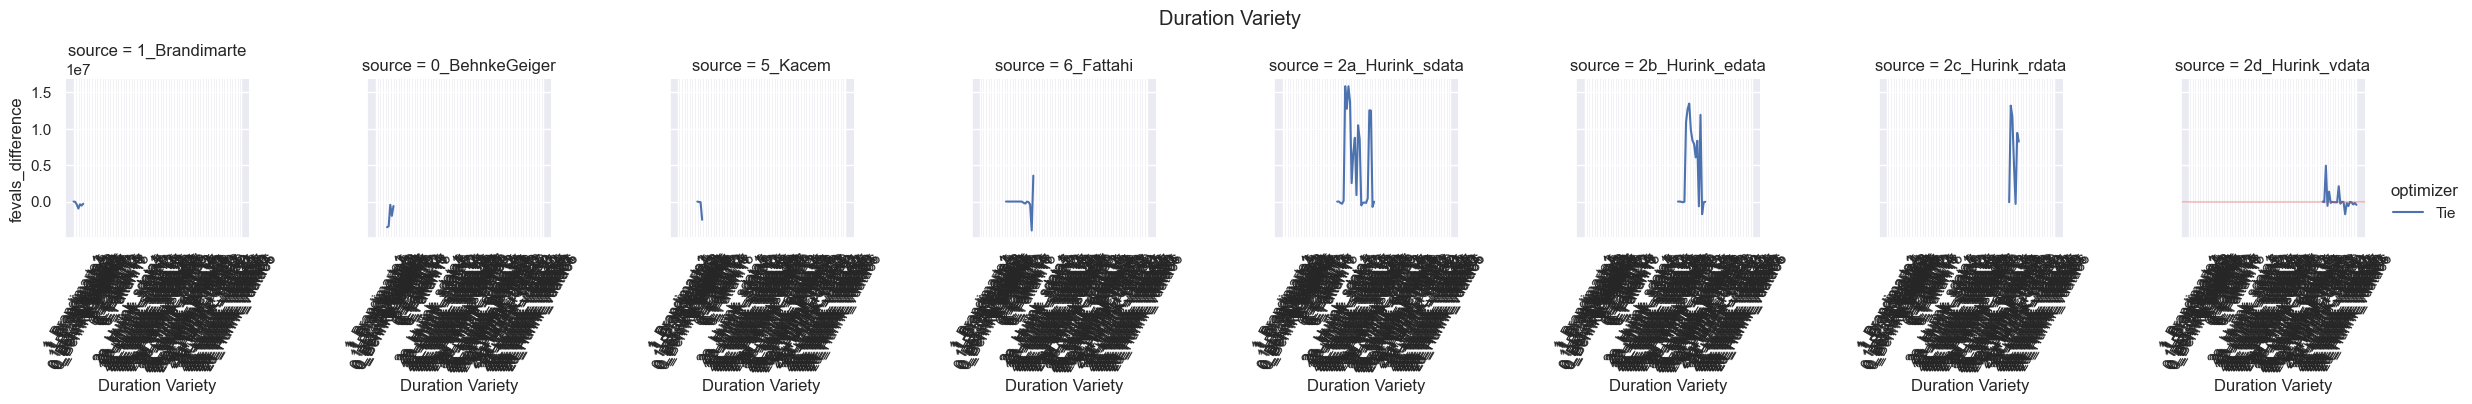

In [87]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=1, col='source')
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
#plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

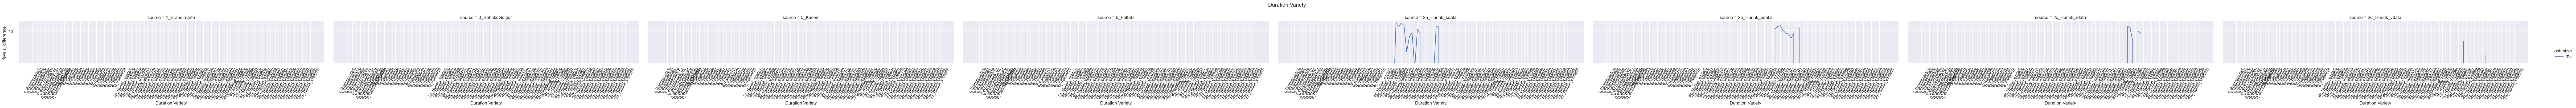

In [88]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=4, col='source')
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

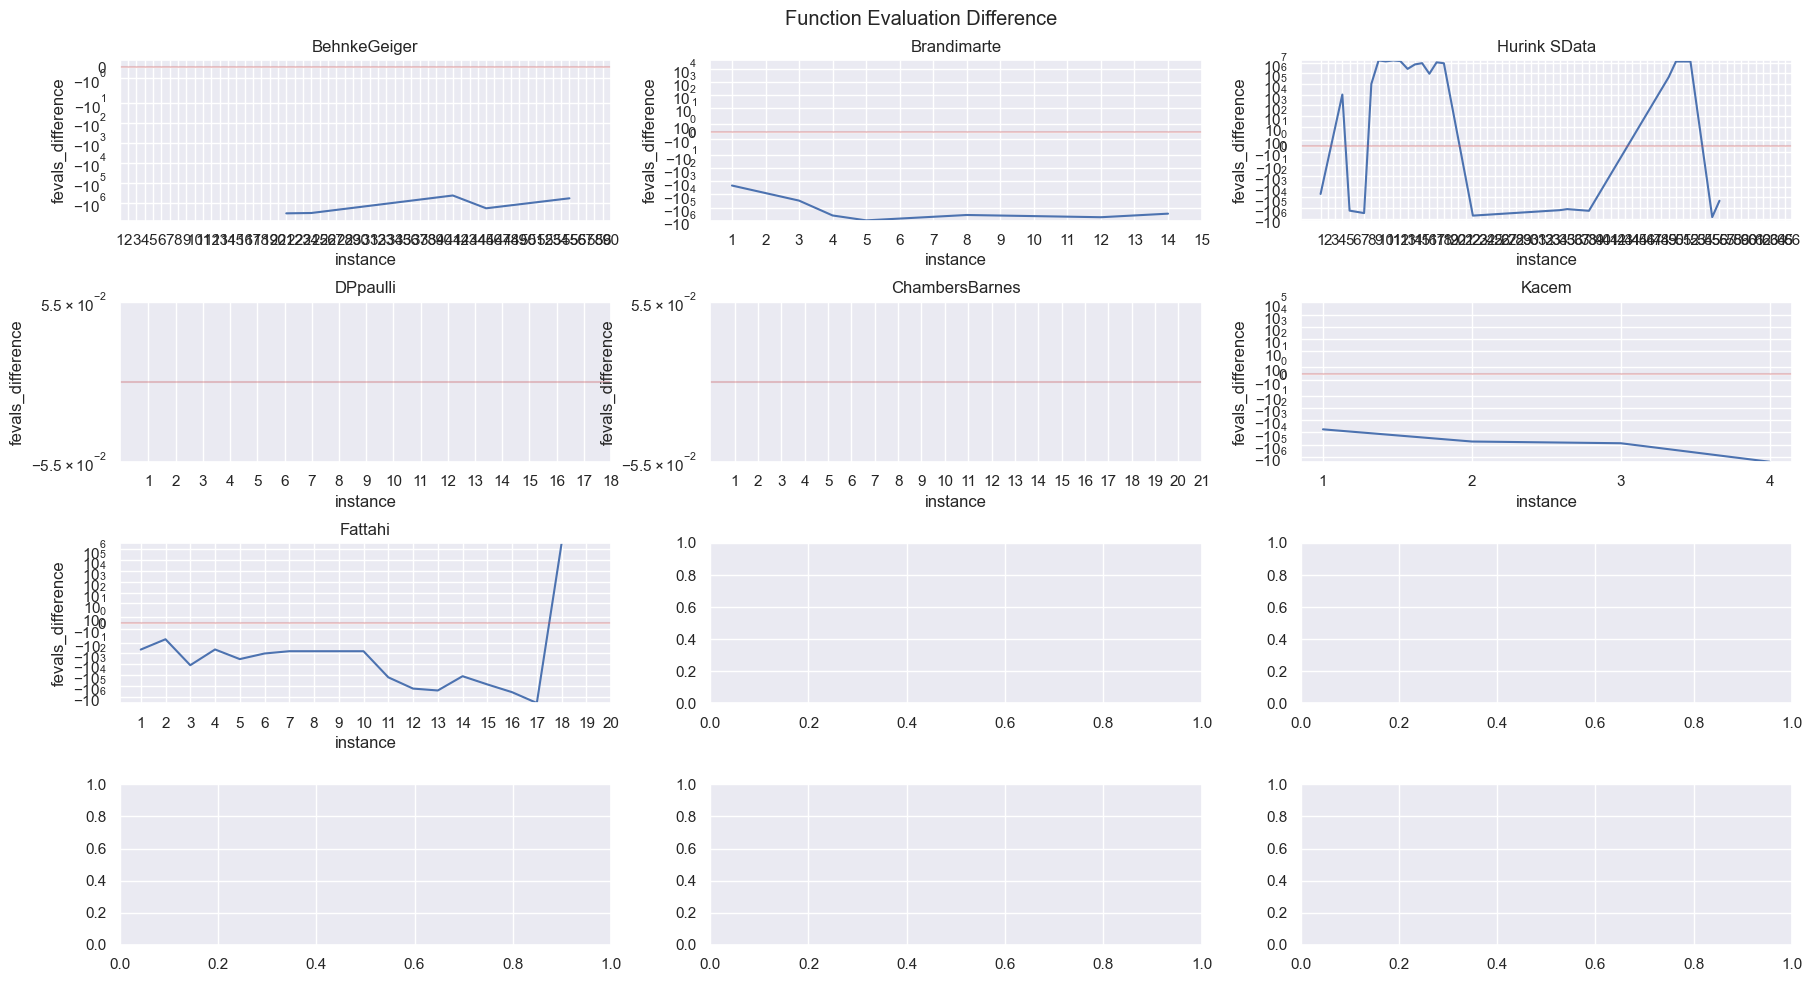

In [89]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
plt.sca(axes[0,0])
plt.xticks(range(1, 61))
axes[0,0].set_title('BehnkeGeiger')
axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,1])
plt.xticks(range(1, 16))
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,2])
plt.xticks(range(1, 67))
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,0])
plt.xticks(range(1, 19))
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,1])
plt.xticks(range(1, 22))
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,2])
plt.xticks(range(1, 5))
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[2,0])
plt.xticks(range(1, 21))
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

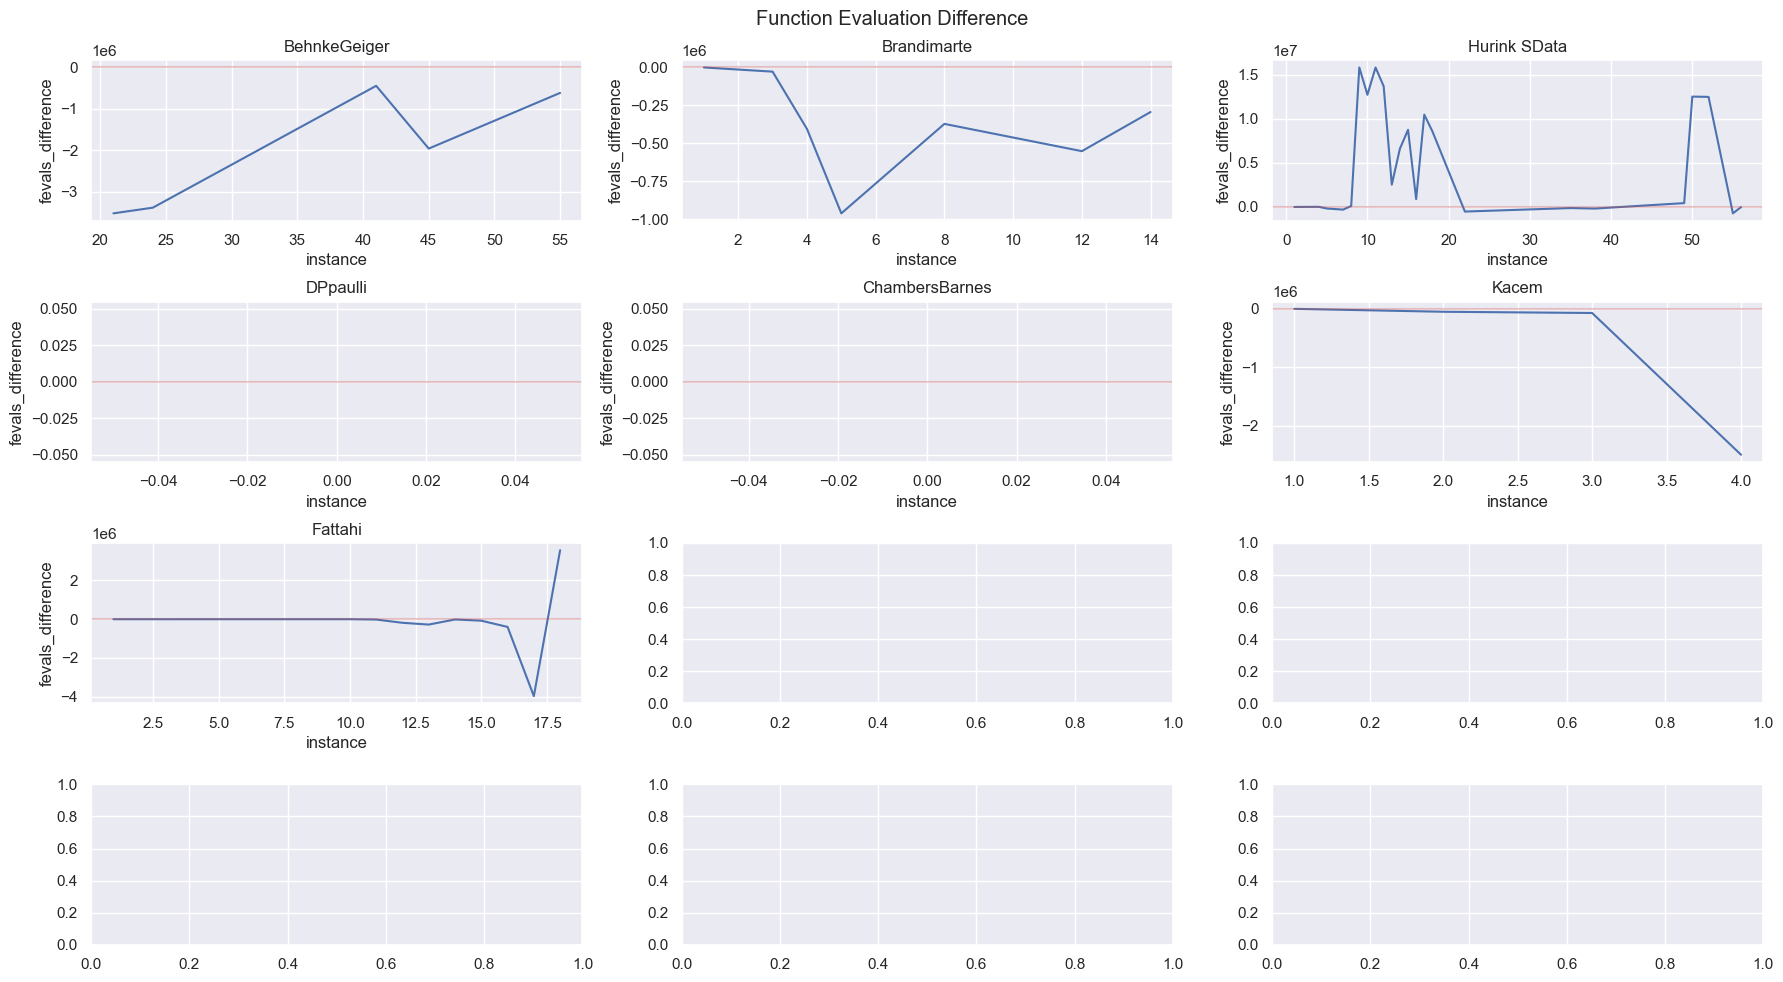

In [90]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
#axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
#axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
#axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
#axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
#axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
#axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

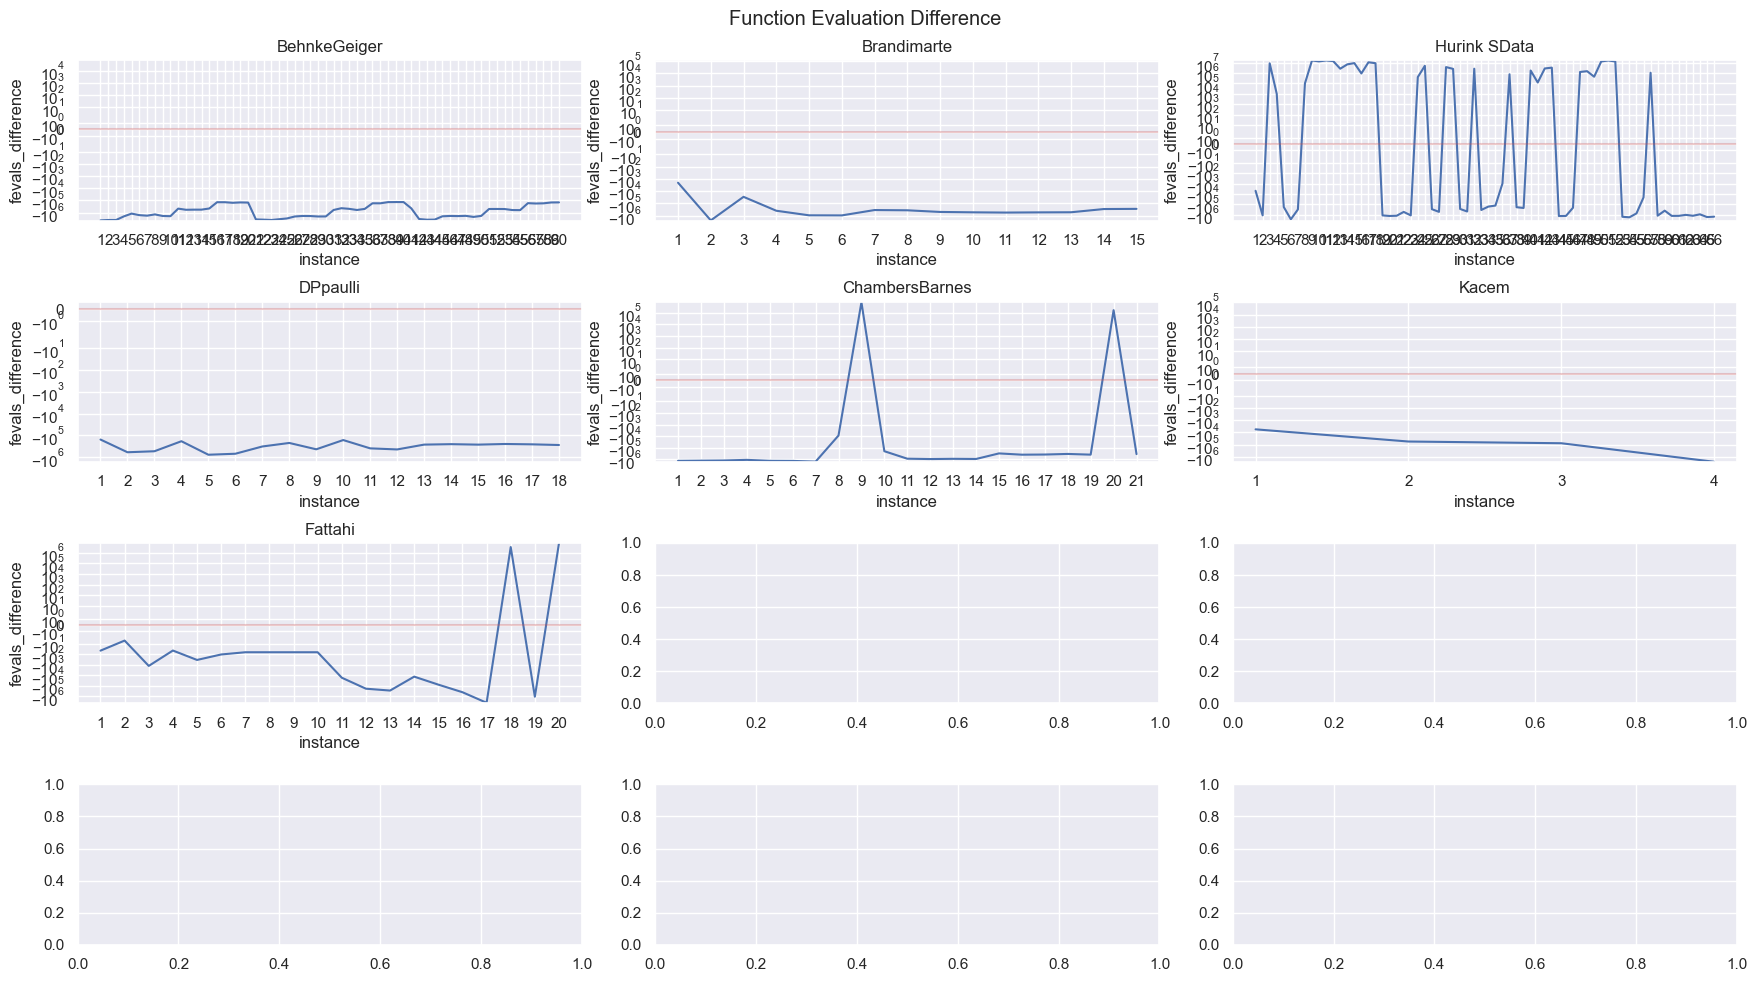

In [91]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
plt.sca(axes[0,0])
plt.xticks(range(1, 61))
axes[0,0].set_title('BehnkeGeiger')
axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,1])
plt.xticks(range(1, 16))
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,2])
plt.xticks(range(1, 67))
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,0])
plt.xticks(range(1, 19))
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,1])
plt.xticks(range(1, 22))
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,2])
plt.xticks(range(1, 5))
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[2,0])
plt.xticks(range(1, 21))
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

In [92]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
plt.sca(axes[0,0])
plt.xticks(range(1, 61))
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,1])
plt.xticks(range(1, 16))
axes[0,1].set_title('Brandimarte')
#axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,2])
plt.xticks(range(1, 67))
axes[0,2].set_title('Hurink SData')
#axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,0])
plt.xticks(range(1, 19))
axes[1,0].set_title('DPpaulli')
#axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,1])
plt.xticks(range(1, 22))
axes[1,1].set_title('ChambersBarnes')
#axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,2])
plt.xticks(range(1, 5))
axes[1,2].set_title('Kacem')
#axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[2,0])
plt.xticks(range(1, 21))
axes[2,0].set_title('Fattahi')
#axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

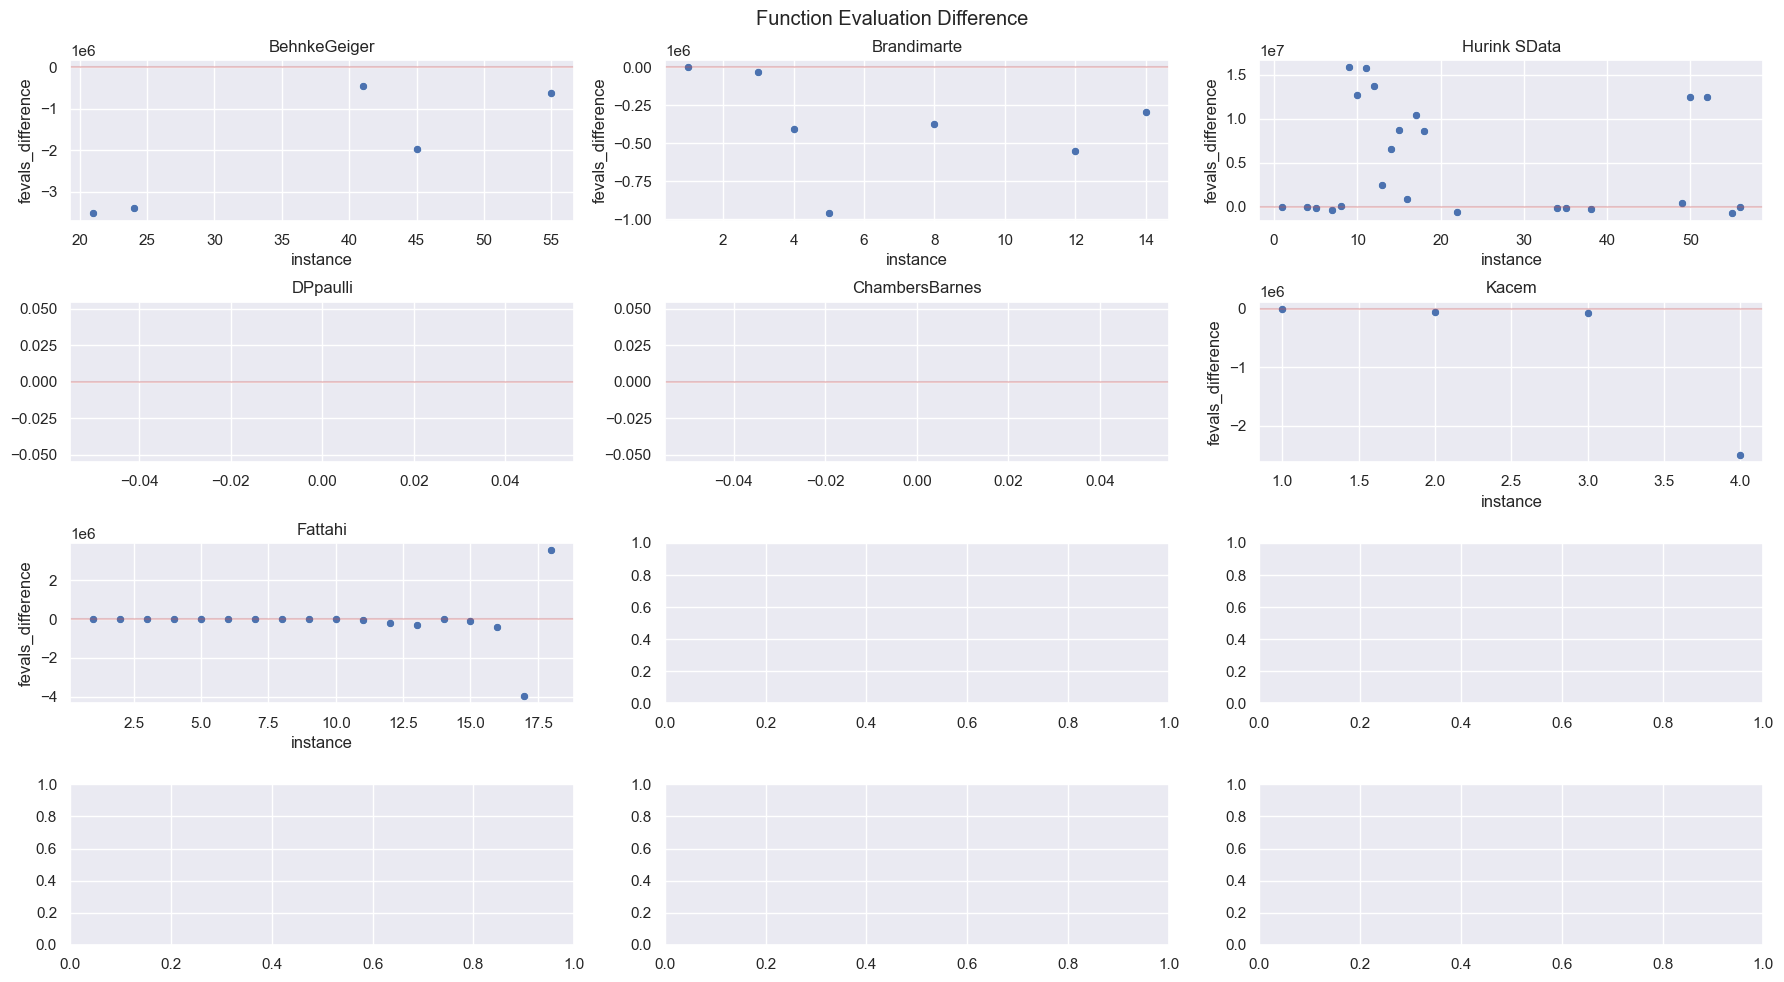

In [93]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
#axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
#axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
#axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
#axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
#axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
#axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

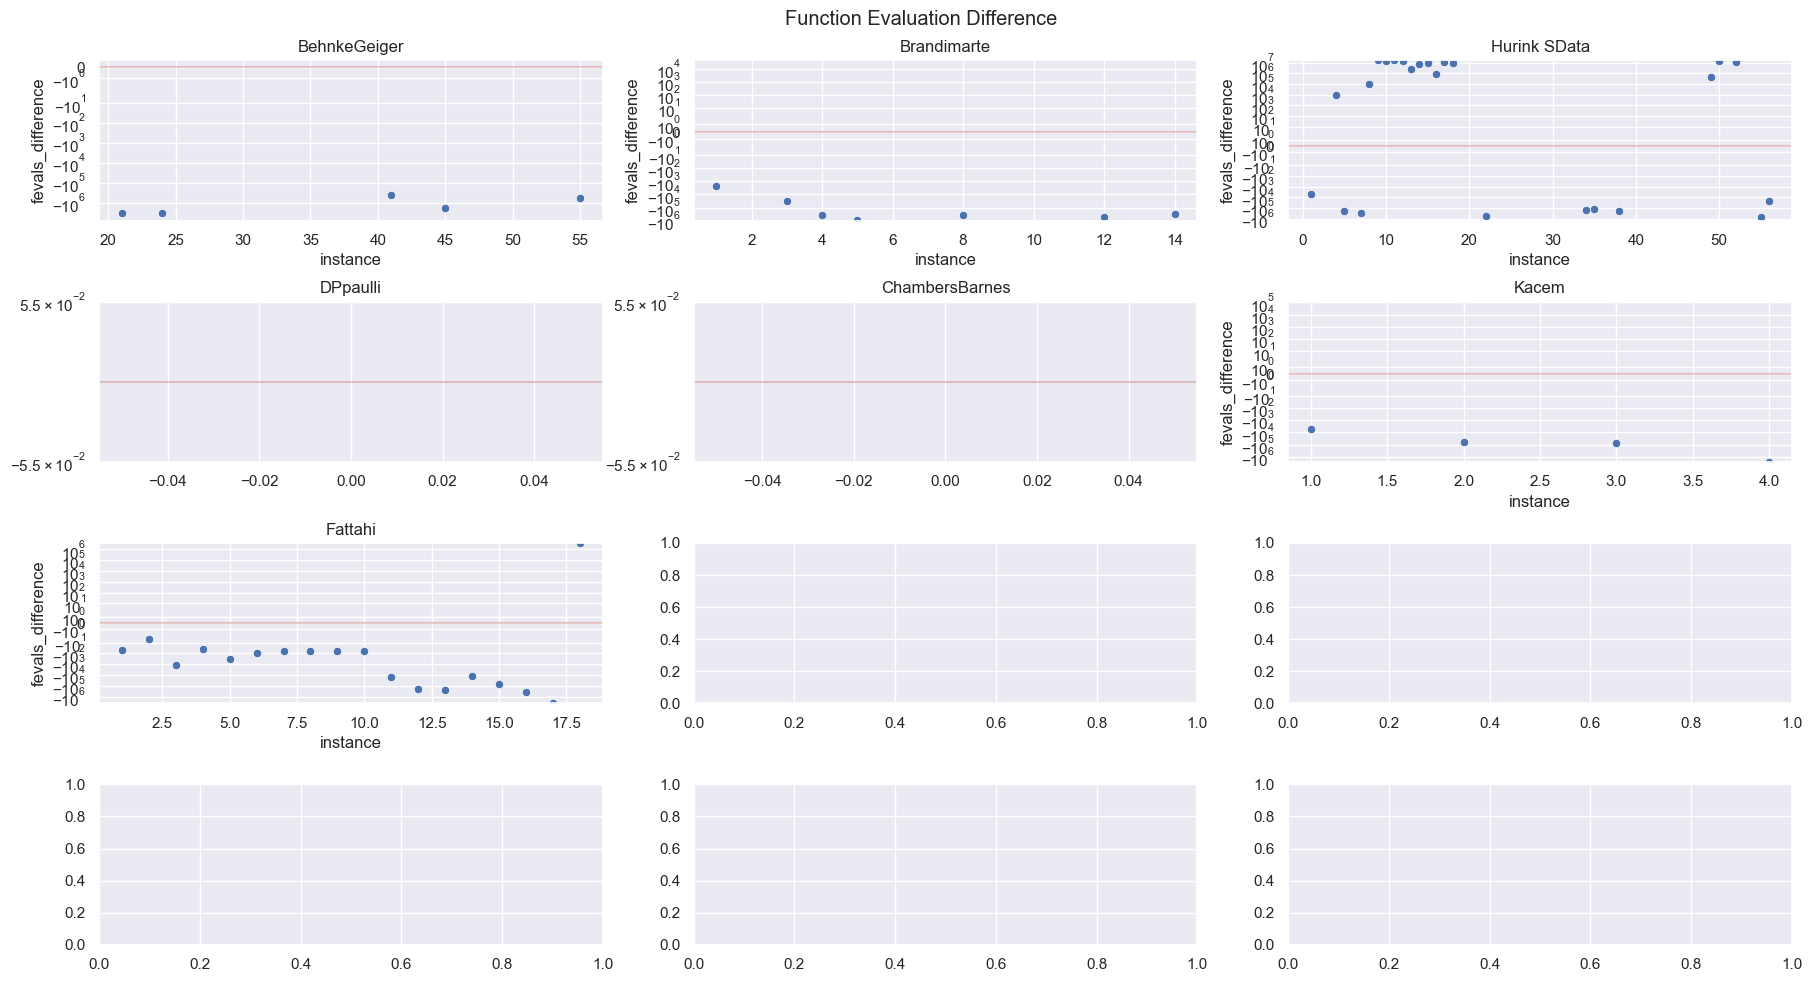

In [94]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

In [95]:
def absolute(x):
    return abs(x)

def inverse(x):
    return -x

fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='difference', y='fevals_difference', ax=axes[0,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='difference', y='fevals_difference', ax=axes[0,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='difference', y='fevals_difference', ax=axes[0,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='difference', y='fevals_difference', ax=axes[1,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='difference', y='fevals_difference', ax=axes[1,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '5_Kacem')], x='difference', y='fevals_difference', ax=axes[1,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '6_Fattahi')], x='difference', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('function', functions=(absolute, absolute))
axes[0,0].set_yscale('symlog')
axes[0,0].set_xscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].set_xscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].set_xscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].set_xscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].set_xscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].set_xscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].set_xscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

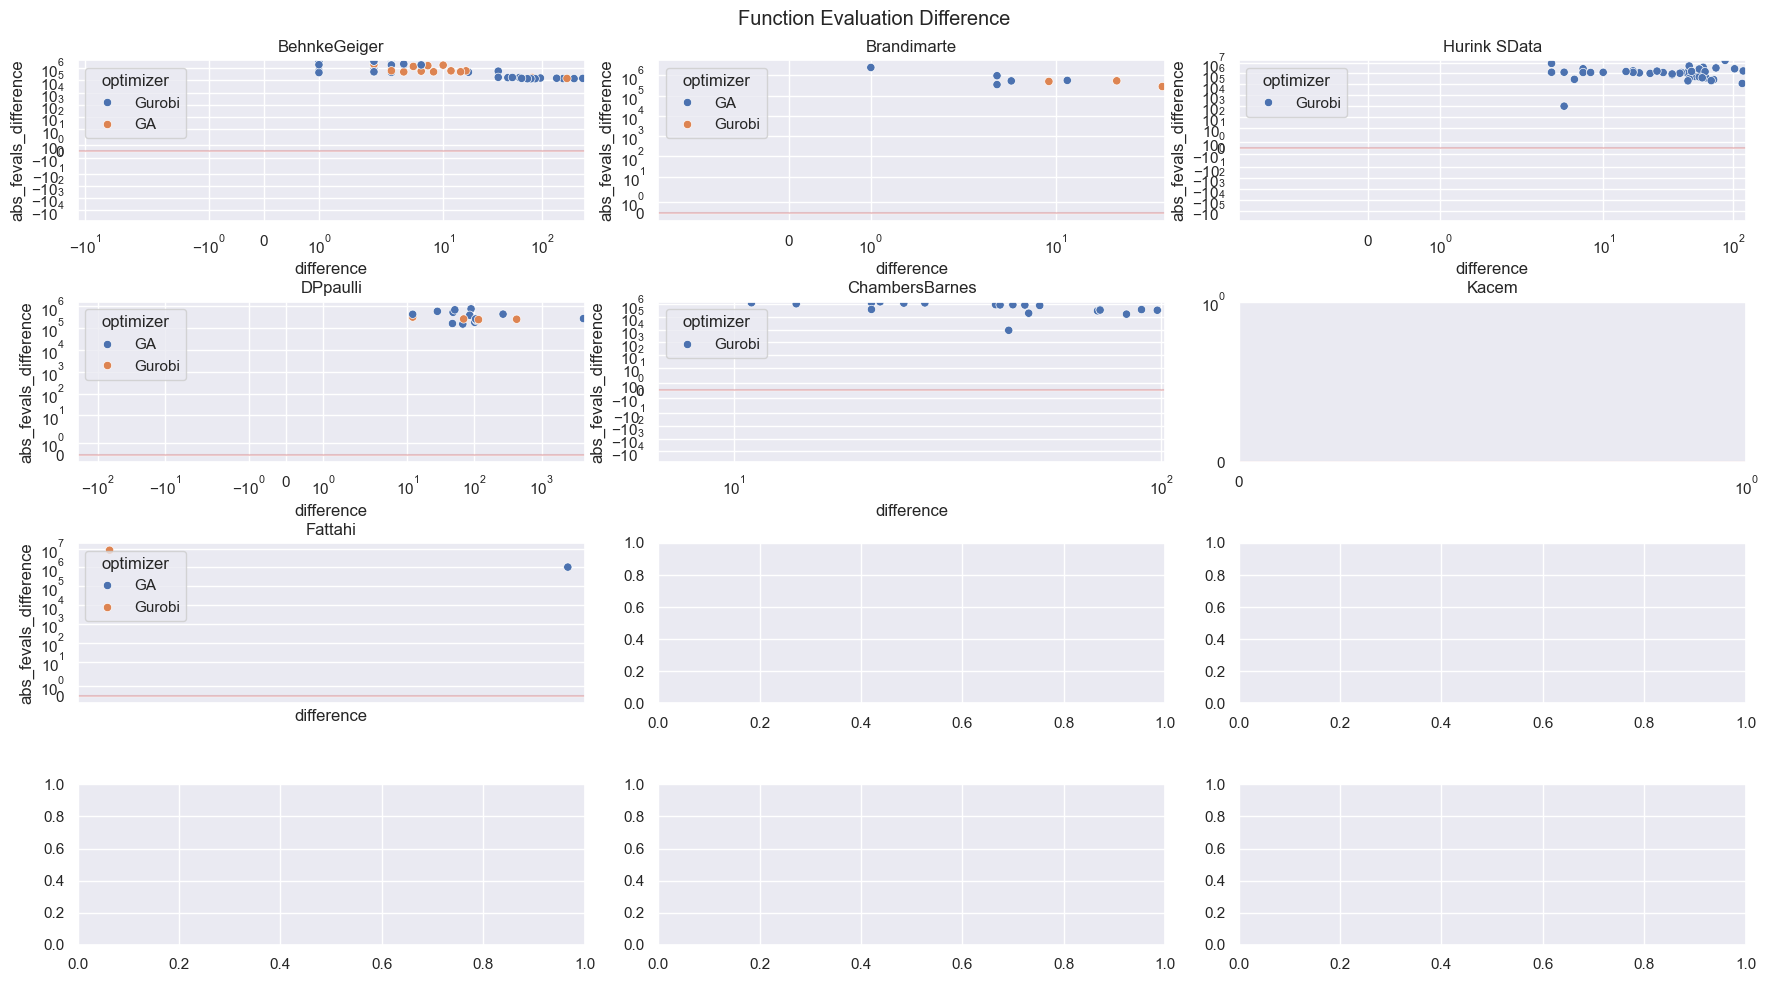

In [96]:
def absolute(x):
    return abs(x)

def inverse(x):
    return -x

fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='difference', y='abs_fevals_difference', ax=axes[0,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='difference', y='abs_fevals_difference', ax=axes[0,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='difference', y='abs_fevals_difference', ax=axes[0,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='difference', y='abs_fevals_difference', ax=axes[1,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='difference', y='abs_fevals_difference', ax=axes[1,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '5_Kacem')], x='difference', y='abs_fevals_difference', ax=axes[1,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '6_Fattahi')], x='difference', y='abs_fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('function', functions=(absolute, absolute))
axes[0,0].set_yscale('symlog')
axes[0,0].set_xscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].set_xscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].set_xscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].set_xscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].set_xscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].set_xscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].set_xscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

C:\Users\huda\AppData\Local\Temp\ipykernel_8548\2456426557.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1,2].set_xscale('log')


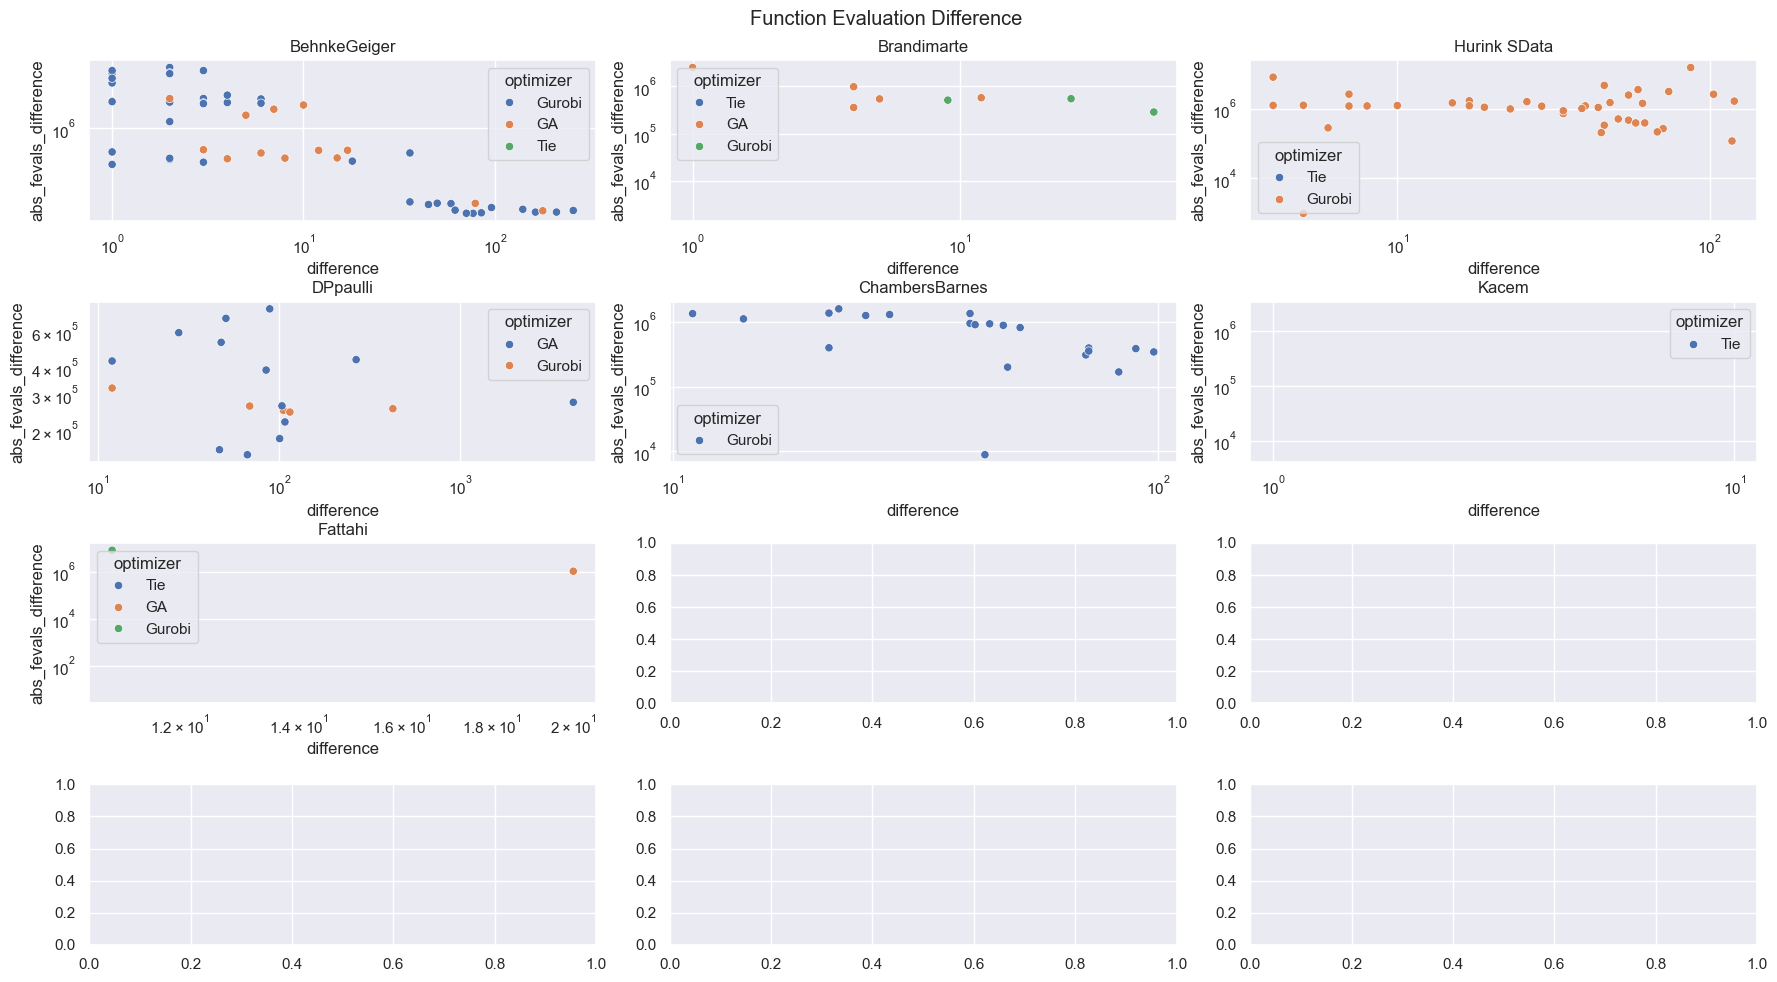

In [97]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '0_BehnkeGeiger')], x='difference', y='abs_fevals_difference', ax=axes[0,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '1_Brandimarte')], x='difference', y='abs_fevals_difference', ax=axes[0,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '2a_Hurink_sdata')], x='difference', y='abs_fevals_difference', ax=axes[0,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '3_DPpaulli')], x='difference', y='abs_fevals_difference', ax=axes[1,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '4_ChambersBarnes')], x='difference', y='abs_fevals_difference', ax=axes[1,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '5_Kacem')], x='difference', y='abs_fevals_difference', ax=axes[1,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '6_Fattahi')], x='difference', y='abs_fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('function', functions=(absolute, absolute))
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('log')
axes[0,1].set_xscale('log')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('log')
axes[0,2].set_xscale('log')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('log')
axes[1,2].set_xscale('log')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('log')
axes[2,0].set_xscale('log')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

In [98]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='abs_fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

In [99]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='instance', y='abs_fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('(Absolute) Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
plt.yscale('log')
plt.show(fg)

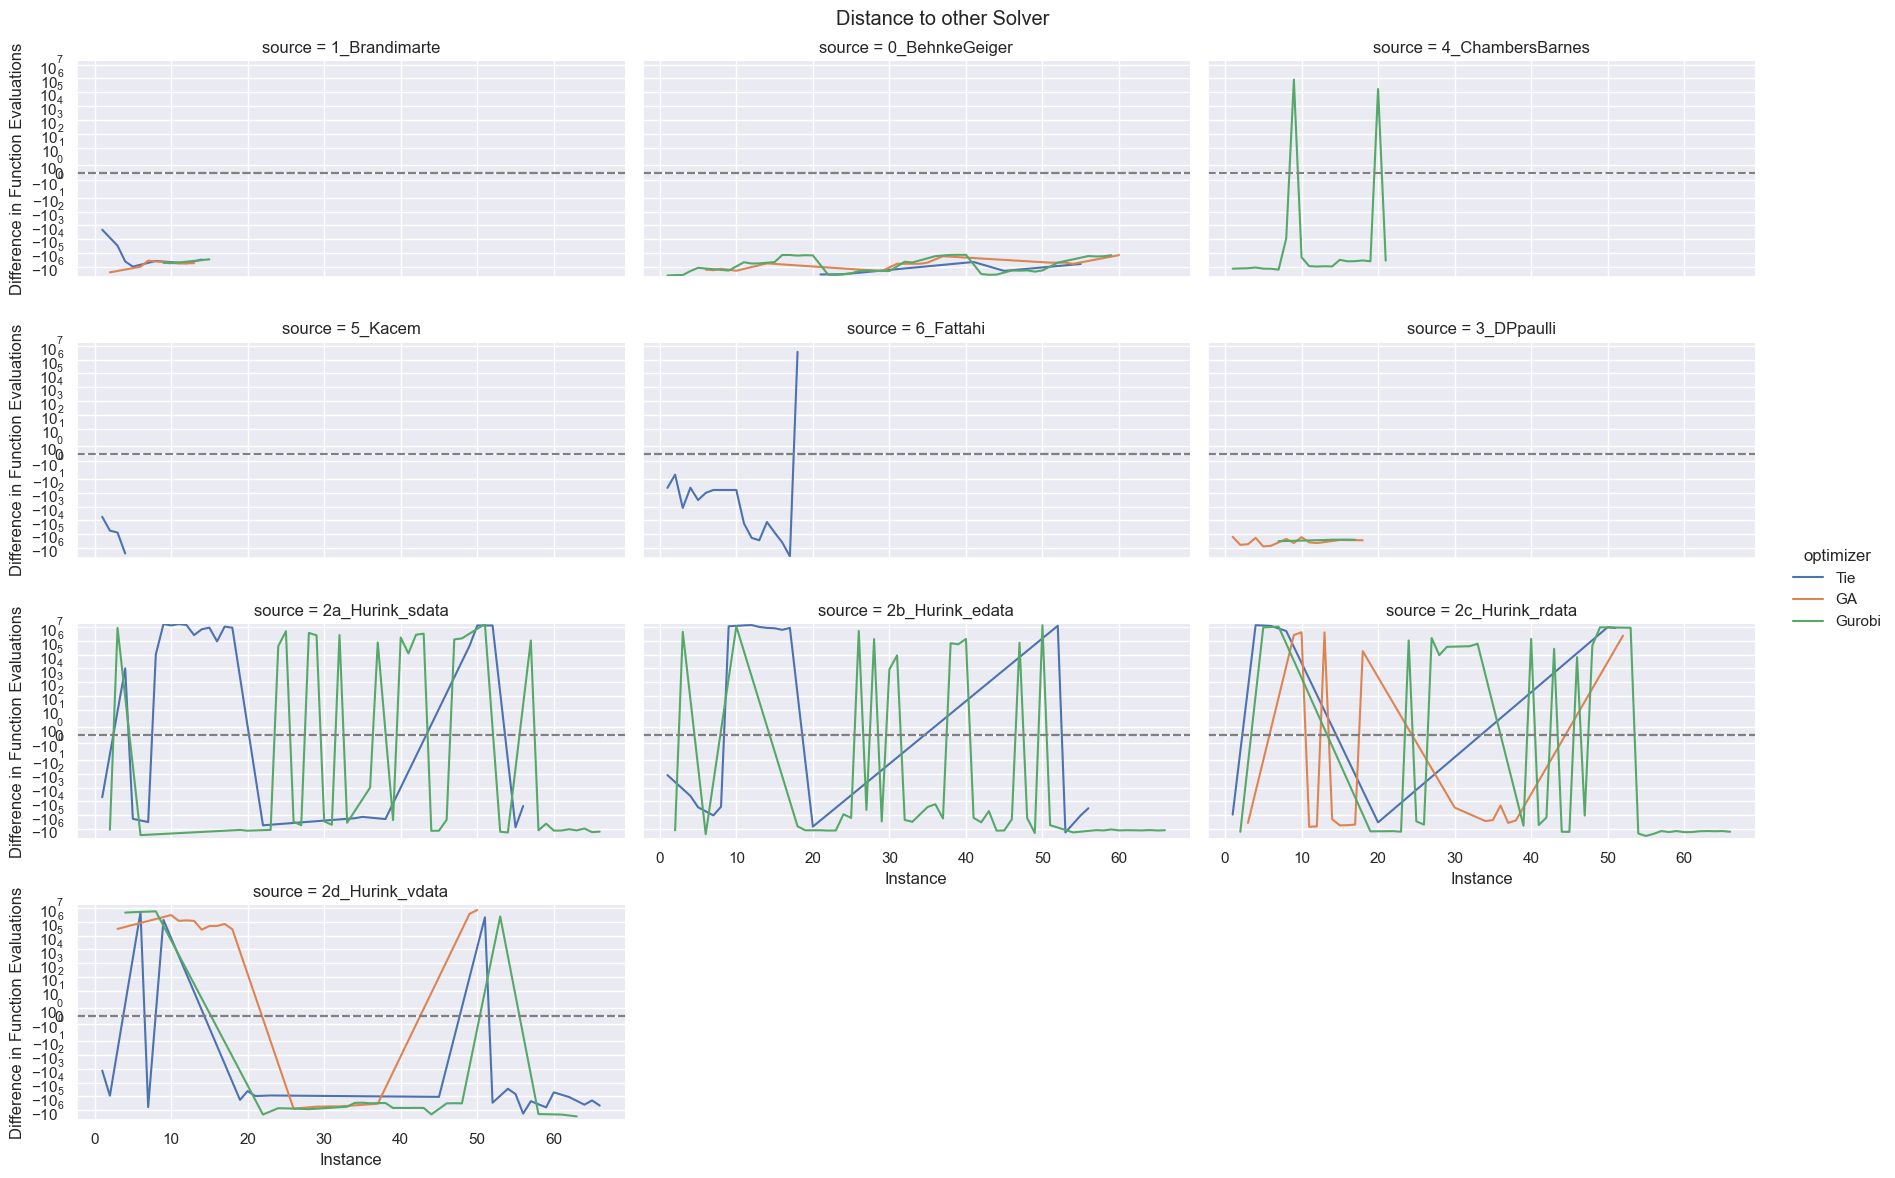

In [100]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.lineplot, x='instance', y='fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
plt.yscale('symlog')
fg.refline(y=0)
plt.show(fg)

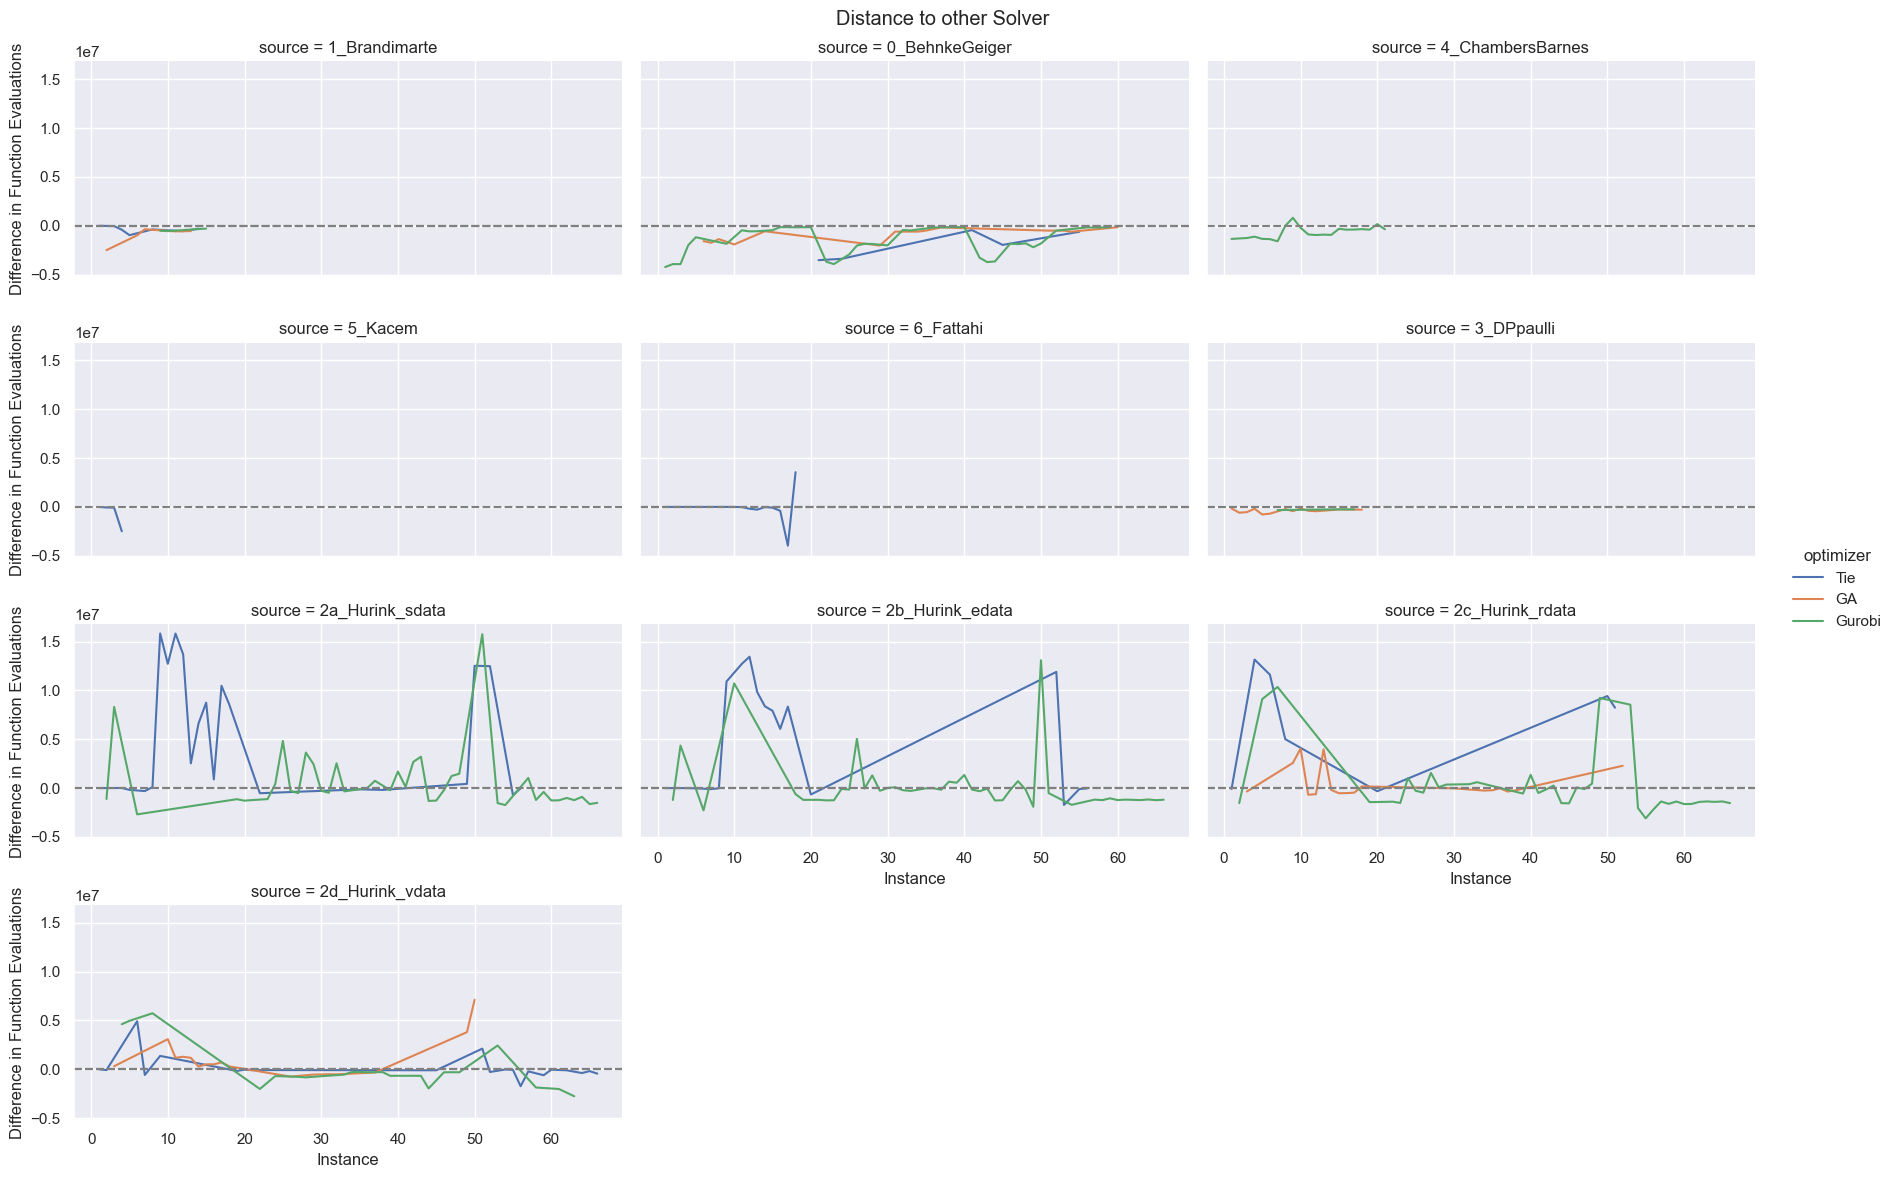

In [101]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.lineplot, x='instance', y='fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
#plt.yscale('symlog')
fg.refline(y=0)
plt.show(fg)

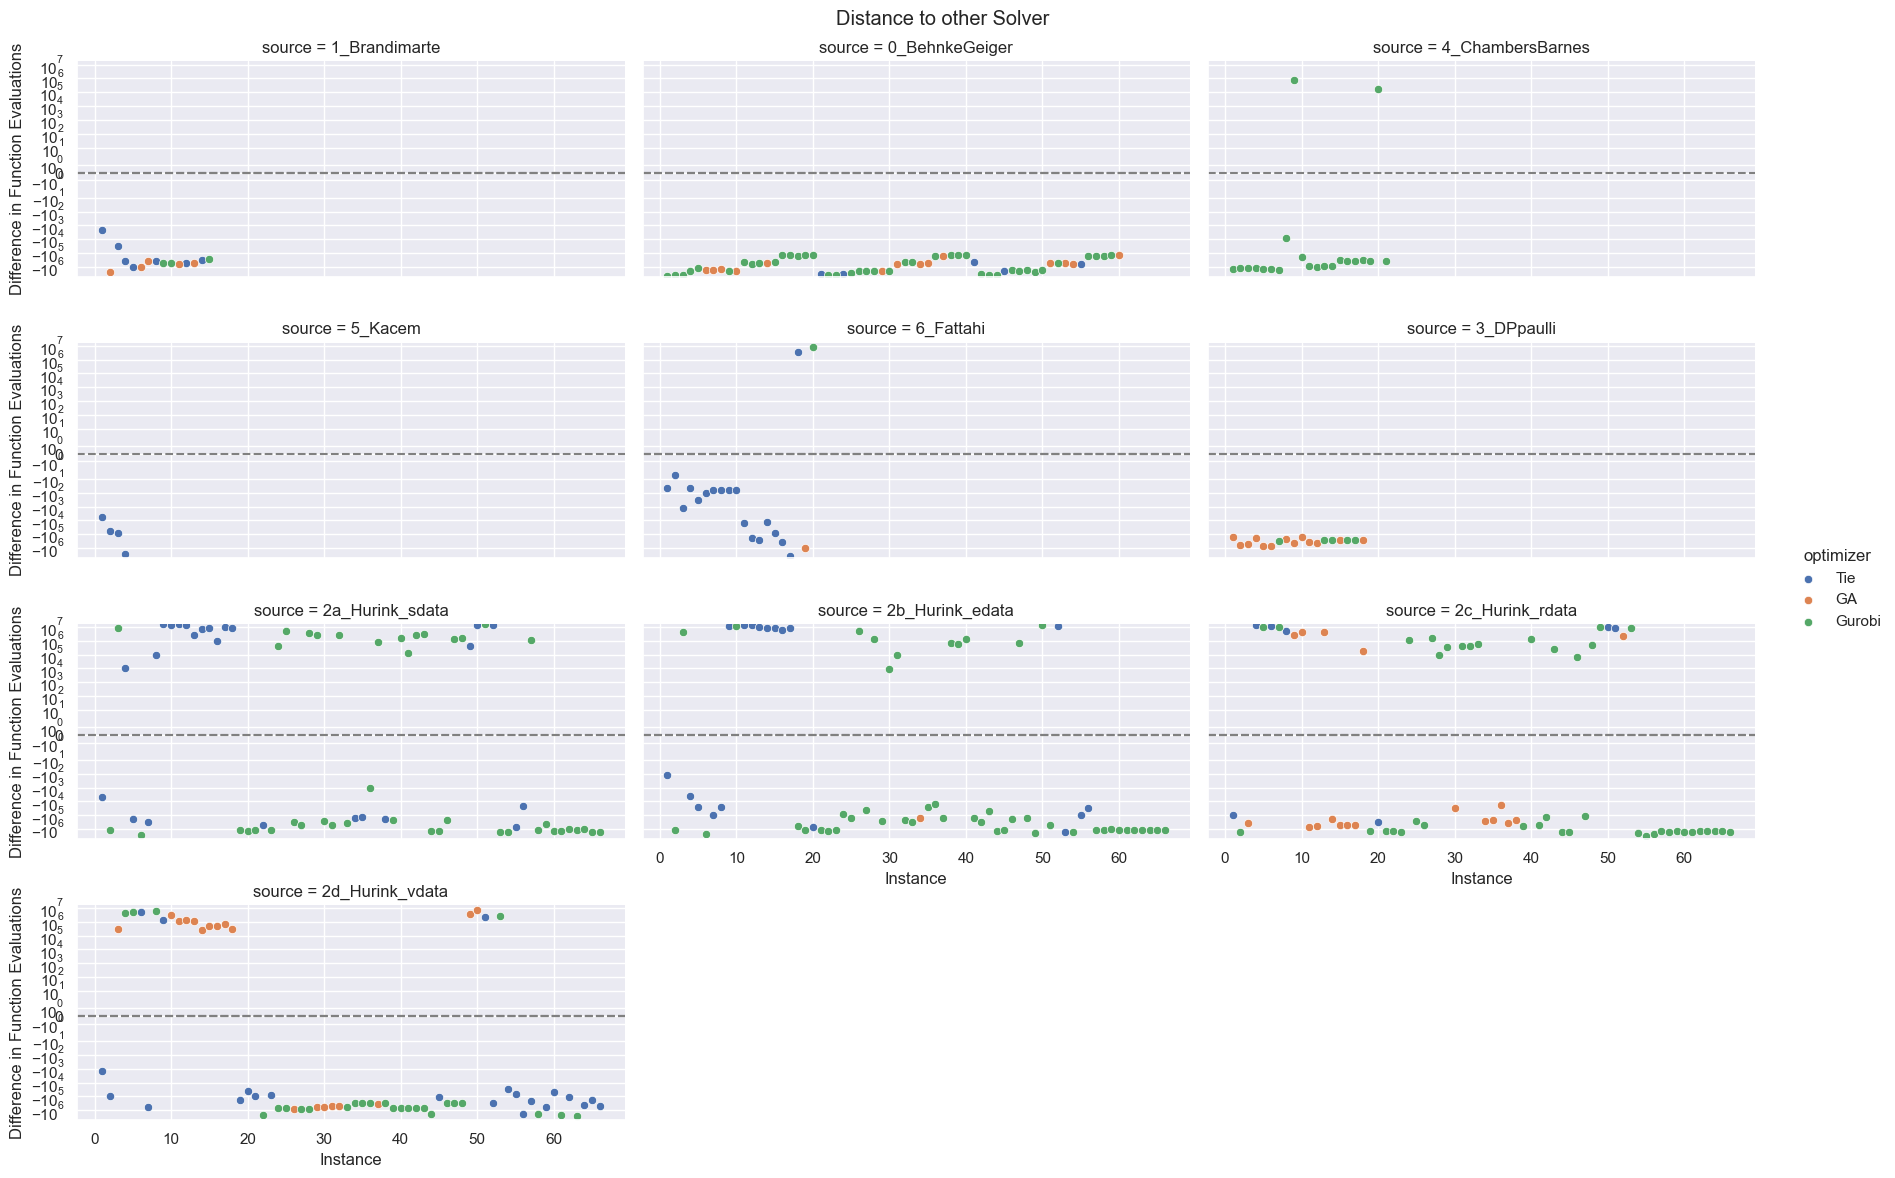

In [102]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='instance', y='fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
plt.yscale('symlog')
fg.refline(y=0)
plt.show(fg)

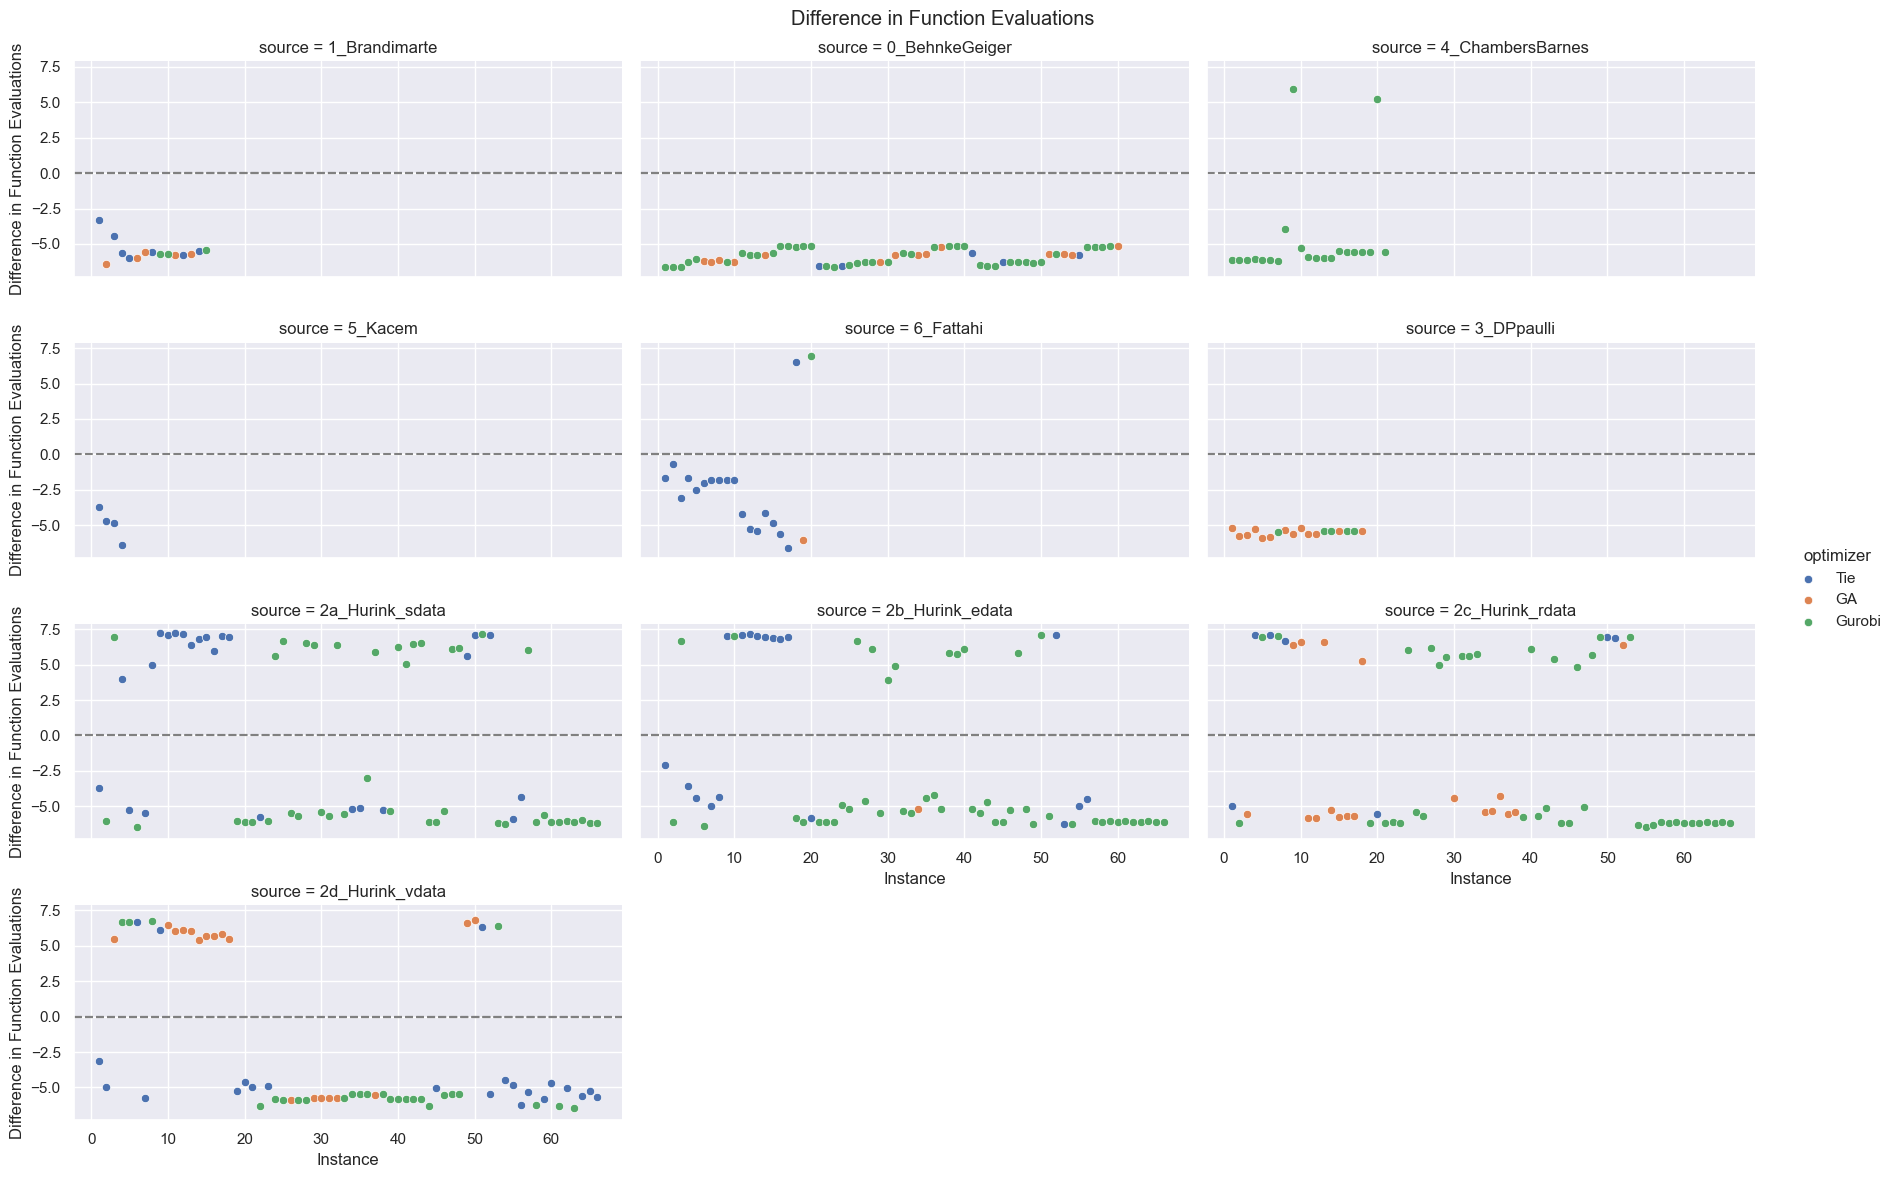

In [103]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Difference in Function Evaluations")
fg.map_dataframe(sns.scatterplot, x='instance', y='log_fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')

fg.refline(y=0)
plt.show(fg)

In [104]:
math.log(1117729)/math.log(10)

6.048336519050205

In [105]:
df_diff.loc[df_diff['source'] == '2a_Hurink_sdata']['abs_fevals_difference']

138       4949
139    1117729
140    8306472
141       9985
142     179545
        ...   
199    1010018
200    1233499
201     894992
202    1637221
203    1507834
Name: abs_fevals_difference, Length: 66, dtype: int64

In [106]:
df_diff.sort_values(by=['difference'], ascending=False)

source  instance                uid  best_objective  n_machines  \
137       3_DPpaulli        18       3_DPpaulli18          2744.0          10   
136       3_DPpaulli        17       3_DPpaulli17          2819.0          10   
131       3_DPpaulli        12       3_DPpaulli12          2197.0           8   
33    0_BehnkeGeiger        19   0_BehnkeGeiger19           801.0          20   
30    0_BehnkeGeiger        16   0_BehnkeGeiger16           811.0          20   
..               ...       ...                ...             ...         ...   
189  2a_Hurink_sdata        52  2a_Hurink_sdata52          8003.0           4   
192  2a_Hurink_sdata        55  2a_Hurink_sdata55          6558.0           7   
193  2a_Hurink_sdata        56  2a_Hurink_sdata56          8264.0           8   
204  2b_Hurink_edata         1   2b_Hurink_edata1            55.0           6   
401  2d_Hurink_vdata        66  2d_Hurink_vdata66           681.0          10   

     n_job  average_machines_per_operation  n_operations  \
137     20                            1.00           387   
136     20                            1.00           387   
131     15                            1.00           293   
33     100                            6.45           500   
30     100                            6.47           500   
..     ...                             ...           ...   
189     14                            1.00            56   
192      7                            1.00            49   
193      8                            1.00            64   
204      6                            1.15            36   
401     10                            5.00           100   

     average_operations_per_job  beta_flexibility  \
137                   19.350000          0.100000   
136                   19.350000          0.100000   
131                   19.533333          0.125000   
33                     5.000000          0.322500   
30                     5.000000          0.323500   
..                          ...               ...   
189                    4.000000          0.250000   
192                    7.000000          0.142857   
193                    8.000000          0.125000   
204                    6.000000          0.191667   
401                   10.000000          0.500000   

     approximate_max_dissimilarity  duration_variety  fevals_GA  \
137                     406.350000          0.045853     275325   
136                     406.350000          0.076125     260850   
131                     312.533333          0.074450     444065   
33                      532.250000          0.006514     144390   
30                      532.350000          0.006489     138590   
..                             ...               ...        ...   
189                      60.000000          0.714286    2242100   
192                      56.000000          0.836735     732415   
193                      72.000000          0.515625      58235   
204                      42.900000          0.214286        125   
401                     150.000000          0.141907     452485   

     fevals_Gurobi  fevals_difference  abs_fevals_difference  \
137            630            -274695                 274695   
136           4842            -256008                 256008   
131           4952            -439113                 439113   
33             694            -143696                 143696   
30             272            -138318                 138318   
..             ...                ...                    ...   
189       14726616           12484516               12484516   
192           2945            -729470                 729470   
193          36941             -21294                  21294   
204              1               -124                    124   
401              1            -452484                 452484   

     log_fevals_difference optimizer  difference source_abbreviation  
137              -5.438851        GA  

In [107]:
pd.options.display.max_rows = 500
df_diff.loc[:, ['source', 'instance', 'optimizer', 'difference']].loc[df_diff['difference'] > 0].sort_values(by=['difference'], ascending=False)

source  instance optimizer  difference
137        3_DPpaulli        18        GA      4221.0
136        3_DPpaulli        17    Gurobi       426.0
131        3_DPpaulli        12        GA       267.0
33     0_BehnkeGeiger        19    Gurobi       257.0
30     0_BehnkeGeiger        16    Gurobi       210.0
95     0_BehnkeGeiger        60        GA       178.0
308   2c_Hurink_rdata        39    Gurobi       164.0
31     0_BehnkeGeiger        17    Gurobi       163.0
310   2c_Hurink_rdata        41    Gurobi       151.0
257   2b_Hurink_edata        54    Gurobi       149.0
245   2b_Hurink_edata        42    Gurobi       147.0
311   2c_Hurink_rdata        42    Gurobi       144.0
34     0_BehnkeGeiger        20    Gurobi       140.0
322   2c_Hurink_rdata        53    Gurobi       133.0
242   2b_Hurink_edata        39    Gurobi       132.0
254   2b_Hurink_edata        51    Gurobi       131.0
382   2d_Hurink_vdata        47    Gurobi       128.0
177   2a_Hurink_sdata        40    Gurobi       120.0
178   2a_Hurink_sdata        41    Gurobi       118.0
316   2c_Hurink_rdata        47    Gurobi       118.0
244   2b_Hurink_edata        41    Gurobi       116.0
135        3_DPpaulli        16    Gurobi       115.0
309   2c_Hurink_rdata        40    Gurobi       115.0
317   2c_Hurink_rdata        48    Gurobi       114.0
381   2d_Hurink_vdata        46    Gurobi       114.0
243   2b_Hurink_edata        40    Gurobi       112.0
253   2b_Hurink_edata        50    Gurobi       110.0
127        3_DPpaulli         8        GA       108.0
246   2b_Hurink_edata        43    Gurobi       106.0
133        3_DPpaulli        14    Gurobi       106.0
134        3_DPpaulli        15        GA       104.0
179   2a_Hurink_sdata        42    Gurobi       103.0
123        3_DPpaulli         4        GA       101.0
89   4_ChambersBarnes        18    Gurobi        98.0
304   2c_Hurink_rdata        35        GA        97.0
315   2c_Hurink_rdata        46    Gurobi        97.0
312   2c_Hurink_rdata        43    Gurobi        97.0
370   2d_Hurink_vdata        35    Gurobi        96.0
32     0_BehnkeGeiger        18    Gurobi        96.0
383   2d_Hurink_vdata        48    Gurobi        95.0
250   2b_Hurink_edata        47    Gurobi        92.0
88   4_ChambersBarnes        17    Gurobi        90.0
323   2c_Hurink_rdata        54    Gurobi        90.0
124        3_DPpaulli         5        GA        89.0
188   2a_Hurink_sdata        51    Gurobi        87.0
130        3_DPpaulli        11        GA        85.0
52     0_BehnkeGeiger        38    Gurobi        85.0
91   4_ChambersBarnes        20    Gurobi        83.0
307   2c_Hurink_rdata        38        GA        82.0
369   2d_Hurink_vdata        34    Gurobi        80.0
294   2c_Hurink_rdata        25    Gurobi        80.0
51     0_BehnkeGeiger        37        GA        79.0
230   2b_Hurink_edata        27    Gurobi        78.0
53     0_BehnkeGeiger        39    Gurobi        77.0
252   2b_Hurink_edata        49    Gurobi        77.0
293   2c_Hurink_rdata        24    Gurobi        76.0
180   2a_Hurink_sdata        43    Gurobi        74.0
90   4_ChambersBarnes        19    Gurobi        72.0
92   4_ChambersBarnes        21    Gurobi        72.0
377   2d_Hurink_vdata        42    Gurobi        72.0
54     0_BehnkeGeiger        40    Gurobi        71.0
167   2a_Hurink_sdata        30    Gurobi        71.0
86   4_ChambersBarnes        15    Gurobi        71.0
132        3_DPpaulli        13    Gurobi        69.0
234   2b_Hurink_edata        31    Gurobi        69.0
176   2a_Hurink_sdata        39    Gurobi        68.0
228   2b_Hurink_edata        25    Gurobi        67.0
232   2b_Hurink_edata        29    Gurobi        67.0
120        3_DPpaulli         1        GA        67.0
233   2b_Hurink_edata        30    Gurobi        67.0
373   2d_Hurink_vdata        38    Gurobi        66.0
297   2c_Hurink_rdata        28    Gurobi        64.0
371   2d_Hurink_vdata        36    Gurobi        64.0
374   2d_Hurink_vda

In [108]:
df_diff.loc[df_diff['difference'] == 0]

source  instance                uid  best_objective  n_machines  \
0      1_Brandimarte         1     1_Brandimarte1            40.0           6   
2      1_Brandimarte         3     1_Brandimarte3           204.0           8   
3      1_Brandimarte         4     1_Brandimarte4            60.0           8   
4      1_Brandimarte         5     1_Brandimarte5           173.0           4   
7      1_Brandimarte         8     1_Brandimarte8           523.0          10   
11     1_Brandimarte        12    1_Brandimarte12           508.0          10   
13     1_Brandimarte        14    1_Brandimarte14           694.0          15   
35    0_BehnkeGeiger        21   0_BehnkeGeiger21            88.0          40   
38    0_BehnkeGeiger        24   0_BehnkeGeiger24            87.0          40   
55    0_BehnkeGeiger        41   0_BehnkeGeiger41            87.0          60   
59    0_BehnkeGeiger        45   0_BehnkeGeiger45            87.0          60   
69    0_BehnkeGeiger        55   0_BehnkeGeiger55           253.0          60   
96           5_Kacem         1           5_Kacem1            11.0           5   
97           5_Kacem         2           5_Kacem2            11.0           7   
98           5_Kacem         3           5_Kacem3             7.0          10   
99           5_Kacem         4           5_Kacem4            11.0          10   
100        6_Fattahi         1         6_Fattahi1            66.0           2   
101        6_Fattahi         2         6_Fattahi2           107.0           2   
102        6_Fattahi         3         6_Fattahi3           221.0           2   
103        6_Fattahi         4         6_Fattahi4           355.0           2   
104        6_Fattahi         5         6_Fattahi5           119.0           2   
105        6_Fattahi         6         6_Fattahi6           320.0           3   
106        6_Fattahi         7         6_Fattahi7           397.0           5   
107        6_Fattahi         8         6_Fattahi8           253.0           4   
108        6_Fattahi         9         6_Fattahi9           210.0           3   
109        6_Fattahi        10        6_Fattahi10           516.0           5   
110        6_Fattahi        11        6_Fattahi11           468.0           6   
111        6_Fattahi        12        6_Fattahi12           446.0           7   
112        6_Fattahi        13        6_Fattahi13           466.0           7   
113        6_Fattahi        14        6_Fattahi14           554.0           7   
114        6_Fattahi        15        6_Fattahi15           514.0           7   
115        6_Fattahi        16        6_Fattahi16           634.0           7   
116        6_Fattahi        17        6_Fattahi17           879.0           7   
117        6_Fattahi        18        6_Fattahi18           884.0           8   
138  2a_Hurink_sdata         1   2a_Hurink_sdata1            55.0           6   
141  2a_Hurink_sdata         4   2a_Hurink_sdata4           666.0           5   
142  2a_Hurink_sdata         5   2a_Hurink_sdata5           655.0           5   
144  2a_Hurink_sdata         7   2a_Hurink_sdata7           590.0           5   
145  2a_Hurink_sdata         8   2a_Hurink_sdata8           593.0           5   
146  2a_Hurink_sdata         9   2a_Hurink_sdata9           926.0           5   
147  2a_Hurink_sdata        10  2a_Hurink_sdata10           890.0           5   
148  2a_Hurink_sdata        11  2a_Hurink_sdata11           863.0           5   
149  2a_Hurink_sdata        12  2a_Hurink_sdata12           951.0           5   
150  2a_Hurink_sdata        13  2a_Hurink_sdata13           958.0           5   
151  2a_Hurink_sdata        14  2a_Hurink_sdata14          1222.0           5   
152  2a_Hurink_sdata        15  2a_Hurink_sdata15          1039.0           5   
153  2a_Hurink_sdata        16  2a_Hurink_sdata16          1150.0           5   
154  2a_Hurink_sdata        17  2a_Hurink_sdata17          1292.0           5   
155  2a_Hurink_sdata        18  2a_Hurink_sda

In [109]:
df_diff.loc[:, ['source', 'instance', 'best_objective', 'optimizer', 'difference']].loc[(df_diff['difference'] > 0) & (df_diff['source'] == '0_BehnkeGeiger')].sort_values(by=['difference'], ascending=False)

source  instance  best_objective optimizer  difference
33  0_BehnkeGeiger        19           801.0    Gurobi       257.0
30  0_BehnkeGeiger        16           811.0    Gurobi       210.0
95  0_BehnkeGeiger        60           531.0        GA       178.0
31  0_BehnkeGeiger        17           759.0    Gurobi       163.0
34  0_BehnkeGeiger        20           768.0    Gurobi       140.0
32  0_BehnkeGeiger        18           777.0    Gurobi        96.0
52  0_BehnkeGeiger        38           532.0    Gurobi        85.0
51  0_BehnkeGeiger        37           543.0        GA        79.0
53  0_BehnkeGeiger        39           555.0    Gurobi        77.0
54  0_BehnkeGeiger        40           575.0    Gurobi        71.0
94  0_BehnkeGeiger        59           509.0    Gurobi        62.0
50  0_BehnkeGeiger        36           527.0    Gurobi        59.0
93  0_BehnkeGeiger        58           516.0    Gurobi        50.0
70  0_BehnkeGeiger        56           516.0    Gurobi        45.0
27  0_BehnkeGeiger        13           314.0    Gurobi        36.0
71  0_BehnkeGeiger        57           513.0    Gurobi        36.0
25  0_BehnkeGeiger        11           312.0    Gurobi        18.0
48  0_BehnkeGeiger        34           256.0        GA        17.0
67  0_BehnkeGeiger        53           251.0        GA        15.0
45  0_BehnkeGeiger        31           270.0        GA        12.0
21  0_BehnkeGeiger         7           135.0        GA        10.0
65  0_BehnkeGeiger        51           257.0        GA         8.0
20  0_BehnkeGeiger         6           135.0        GA         7.0
64  0_BehnkeGeiger        50           131.0    Gurobi         6.0
44  0_BehnkeGeiger        30           129.0    Gurobi         6.0
28  0_BehnkeGeiger        14           313.0        GA         6.0
22  0_BehnkeGeiger         8           133.0        GA         5.0
49  0_BehnkeGeiger        35           250.0        GA         4.0
23  0_BehnkeGeiger         9           134.0    Gurobi         4.0
63  0_BehnkeGeiger        49           120.0    Gurobi         4.0
60  0_BehnkeGeiger        46           123.0    Gurobi         3.0
16  0_BehnkeGeiger         2            94.0    Gurobi         3.0
40  0_BehnkeGeiger        26           121.0    Gurobi         3.0
68  0_BehnkeGeiger        54           260.0        GA         3.0
29  0_BehnkeGeiger        15           300.0    Gurobi         3.0
62  0_BehnkeGeiger        48           131.0    Gurobi         3.0
42  0_BehnkeGeiger        28           123.0    Gurobi         2.0
18  0_BehnkeGeiger         4            99.0    Gurobi         2.0
19  0_BehnkeGeiger         5            93.0    Gurobi         2.0
66  0_BehnkeGeiger        52           249.0    Gurobi         2.0
58  0_BehnkeGeiger        44            86.0    Gurobi         2.0
43  0_BehnkeGeiger        29           122.0        GA         2.0
57  0_BehnkeGeiger        43            88.0    Gurobi         2.0
47  0_BehnkeGeiger        33           264.0    Gurobi         2.0
41  0_BehnkeGeiger        27           131.0    Gurobi         2.0
15  0_BehnkeGeiger         1            92.0    Gurobi         2.0
61  0_BehnkeGeiger        47           123.0    Gurobi         1.0
56  0_BehnkeGeiger        42            88.0    Gurobi         1.0
26  0_BehnkeGeiger        12           299.0    Gurobi         1.0
24  0_BehnkeGeiger        10           139.0        GA         1.0
36  0_BehnkeGeiger        22            88.0    Gurobi         1.0
37  0_BehnkeGeiger        23            86.0    Gurobi         1.0
39  0_BehnkeGeiger        25            88.0    Gurobi         1.0
46  0_BehnkeGeiger        32           264.0    Gurobi         1.0
17  0_BehnkeGeiger         3            92.0    Gurobi         1.0

In [110]:
df_diff.loc[:, ['source', 'instance', 'best_objective', 'fevals_GA', 'fevals_Gurobi', 'optimizer', 'difference']].loc[(df_diff['difference'] > 0) & (df_diff['source'] == '0_BehnkeGeiger')].sort_values(by=['optimizer'], ascending=False)

source  instance  best_objective  fevals_GA  fevals_Gurobi  \
15  0_BehnkeGeiger         1            92.0    4378925         158083   
58  0_BehnkeGeiger        44            86.0    3771690         123617   
16  0_BehnkeGeiger         2            94.0    4096625         175969   
46  0_BehnkeGeiger        32           264.0     429605           2802   
47  0_BehnkeGeiger        33           264.0     482805           2618   
50  0_BehnkeGeiger        36           527.0     169095             61   
52  0_BehnkeGeiger        38           532.0     136015             31   
53  0_BehnkeGeiger        39           555.0     134375            106   
54  0_BehnkeGeiger        40           575.0     135295            749   
56  0_BehnkeGeiger        42            88.0    3985850         712018   
57  0_BehnkeGeiger        43            88.0    3778490          62715   
60  0_BehnkeGeiger        46           123.0    1990020         162689   
41  0_BehnkeGeiger        27           131.0    2039505         201308   
61  0_BehnkeGeiger        47           123.0    1970180          90056   
62  0_BehnkeGeiger        48           131.0    1888740          92885   
63  0_BehnkeGeiger        49           120.0    2239700          45113   
64  0_BehnkeGeiger        50           131.0    1827240          13655   
66  0_BehnkeGeiger        52           249.0     496165           2924   
70  0_BehnkeGeiger        56           516.0     165910            392   
71  0_BehnkeGeiger        57           513.0     176030             31   
93  0_BehnkeGeiger        58           516.0     170650             31   
94  0_BehnkeGeiger        59           509.0     145135            363   
42  0_BehnkeGeiger        28           123.0    1919020          56007   
44  0_BehnkeGeiger        30           129.0    2073485          68188   
40  0_BehnkeGeiger        26           121.0    2116320          89238   
31  0_BehnkeGeiger        17           759.0     138315             81   
23  0_BehnkeGeiger         9           134.0    2151715         308150   
25  0_BehnkeGeiger        11           312.0     465845           4758   
26  0_BehnkeGeiger        12           299.0     576065           3174   
27  0_BehnkeGeiger        13           314.0     563005           3154   
39  0_BehnkeGeiger        25            88.0    3850525         922555   
29  0_BehnkeGeiger        15           300.0     461565          12069   
30  0_BehnkeGeiger        16           811.0     138590            272   
32  0_BehnkeGeiger        18           777.0     154235            201   
33  0_BehnkeGeiger        19           801.0     144390            694   
19  0_BehnkeGeiger         5            93.0    3882640        2708987   
34  0_BehnkeGeiger        20           768.0     148255            504   
36  0_BehnkeGeiger        22            88.0    3790005         107355   
18  0_BehnkeGeiger         4            99.0    4038785        2042111   
37  0_BehnkeGeiger        23            86.0    3994590          74280   
17  0_BehnkeGeiger         3            92.0    4011785          87914   
68  0_BehnkeGeiger        54           260.0     616585          12670   
65  0_BehnkeGeiger        51           257.0     497645           2687   
20  0_BehnkeGeiger         6           135.0    1890740         316267   
67  0_BehnkeGeiger        53           251.0     500785           3129   
21  0_BehnkeGeiger         7           135.0    1882600         144931   
28  0_BehnkeGeiger        14           313.0     569845          10471   
22  0_BehnkeGeiger         8           133.0    1893680         528464   
24  0_BehnkeGeiger        10           139.0    2134955         225347   
51  0_BehnkeGeiger        37           543.0     170435            297   
49  0_BehnkeGeiger        35           250.0     490325           2320   
48  0_BehnkeGeiger        34           256.0     599245           3105   
45  0_BehnkeGeiger        31           270.0     597165           2145   
43  0_BehnkeGeig

In [111]:
df_diff.loc[:, ['source', 'instance', 'beta_flexibility', 'duration_variety', 'n_machines', 'n_operations', 'n_job']].loc[df_diff['source'] == '6_Fattahi']

source  instance  beta_flexibility  duration_variety  n_machines  \
100  6_Fattahi         1          1.000000          0.875000           2   
101  6_Fattahi         2          0.750000          0.833333           2   
102  6_Fattahi         3          0.850000          0.900000           2   
103  6_Fattahi         4          0.850000          1.000000           2   
104  6_Fattahi         5          1.000000          0.750000           2   
105  6_Fattahi         6          0.533333          0.866667           3   
106  6_Fattahi         7          0.400000          0.944444           5   
107  6_Fattahi         8          0.500000          0.944444           4   
108  6_Fattahi         9          0.666667          0.555556           3   
109  6_Fattahi        10          0.340000          0.850000           5   
110  6_Fattahi        11          0.366667          0.787879           6   
111  6_Fattahi        12          0.385714          0.743590           7   
112  6_Fattahi        13          0.385714          0.708333           7   
113  6_Fattahi        14          0.385714          0.714286           7   
114  6_Fattahi        15          0.371429          0.690909           7   
115  6_Fattahi        16          0.371429          0.677419           7   
116  6_Fattahi        17          0.342857          0.589744           7   
117  6_Fattahi        18          0.300000          0.546512           8   
118  6_Fattahi        19          0.287500          0.456311           8   
119  6_Fattahi        20          0.287500          0.455357           8   

     n_operations  n_job  
100             4      2  
101             4      2  
102             6      3  
103             6      3  
104             6      3  
105             9      3  
106             9      3  
107             9      3  
108             9      3  
109            12      4  
110            15      5  
111            15      5  
112            18      6  
113            21      7  
114            21      7  
115            24      8  
116            32      8  
117            36      9  
118            44     11  
119            48     12